# Projet 08 : Communiquer des résultats
# Partie 3 : Modélisation - Modélisation des variations futures de prix et de la présence de tendance

---

## <font color=blue>Sommaire</font>

[3. Modélisation](#3_0)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Régression linéaire pour estimer la variation future du prix](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Régression logistique pour modéliser la présence d'une tendance (tendance basée sur les clusters)](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Régression logistique pour modéliser la présence d'une tendance (tendance basée sur les seuils)](#3_4)  

---
**Importation des librairies**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import model_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

import modules_perso.sf_graphiques as sfg
import modules_perso.sf_classification_acp as sfca
import modules_perso.sf_modeles_anova as sfma

<a id='3_0'></a>

---
## <font color=blue>Mission 3 : Modélisation</font>

Je vais mener différentes tentatives de modélisation :  
- une régression linéaire pour estimer la variation future du prix : je m'attends à ce qu'elle ne soit pas performante car la somme des signaux ne smeble pas pouvoir expliquer précisément la variation future du prix, que ce soit à 1 mois, 2 mois ou 3 mois.  
- une régression logistique pour estimer si le marché sera dans une phase de tendance dans le mois, les 2 mois ou les 3 mois à suivre. De la même manière, je m'attends à ce que cette modélisation ne soit pas performante.
- une régression logistique pour estimer si le marché sera dans le top_cluster dans les 2 mois (ou 3 mois) à venir.

Je mène mes études sur l'échantillon aléatoire dans un premier temps. En effet, il est l'échantillon le plus représentatif de l'ensemble de mes données. Je mènerai la même étude sur l'échantillon basé sur les dates dans un deuxième temps, puis je comparerai les résultats.

In [4]:
echant_alea_data21 = pd.read_csv("echantillon_alea_data21.csv", parse_dates=["dateref"])
echant_alea_data21.head()

,contract_id,dateref,category_name,somme_signaux,variation_21_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,9,2015-07-22,LTIR,165,4.013552e-01,8,False,69,31,65,...,-8,-2,25,25,25,-10,0,0,True,True
1,91,2009-06-29,Metals,30,5.976307e-02,2,False,7,23,0,...,17,14,-25,-25,-25,25,25,25,True,False
2,32,2009-08-14,STIR,416,5.403889e-01,0,True,150,116,150,...,23,20,25,25,25,25,25,25,True,True
3,6,2010-02-26,Currencies,67,-4.207197e-01,6,False,59,-6,14,...,-4,-2,25,25,11,-25,-25,3,True,True
4,37,2011-08-18,STIR,432,-3.030987e-13,1,False,150,132,150,...,21,17,25,25,25,25,25,25,False,False


In [5]:
echant_alea_data42 = pd.read_csv("echantillon_alea_data42.csv", parse_dates=["dateref"])
echant_alea_data42.head()

,contract_id,dateref,category_name,somme_signaux,variation_42_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,13,2013-12-26,LTIR,136,0.492840,6,False,29,39,68,...,18,11,-3,-4,0,25,25,25,False,True
1,12,1991-05-03,LTIR,0,-0.069842,0,False,0,0,0,...,0,0,0,0,0,0,0,0,True,False
2,15,1991-01-04,LTIR,0,-0.144532,0,False,0,0,0,...,0,0,0,0,0,0,0,0,True,False
3,23,2001-06-22,Energy,-200,-0.368365,9,False,-54,-99,-47,...,-25,-25,18,7,3,-25,-25,-25,True,True
4,26,2006-06-15,Energy,343,0.362887,8,False,146,59,138,...,14,15,25,25,25,25,25,13,True,True


In [6]:
echant_alea_data64 = pd.read_csv("echantillon_alea_data64.csv", parse_dates=["dateref"])
echant_alea_data64.head()

,contract_id,dateref,category_name,somme_signaux,variation_64_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,44,2002-05-16,Index,-59,-0.655845,8,False,0,-20,-39,...,2,2,-25,-25,-25,25,-2,13,False,True
1,25,2009-03-31,Energy,-380,0.694890,9,False,-150,-109,-121,...,-20,-25,-25,-14,-7,-25,-25,-25,True,True
2,59,1990-06-11,Index,0,-0.621847,8,False,0,0,0,...,0,0,0,0,0,0,0,0,False,True
3,25,1993-05-11,Energy,18,-0.861281,8,False,12,30,-24,...,17,10,-25,-25,-25,25,25,1,False,True
4,33,1997-09-15,STIR,424,0.346597,0,False,150,124,150,...,25,24,25,25,25,25,25,25,True,False


<a id='3_2'></a>

## 3.2. Régression linéaire pour estimer la variation future du prix

### 3.2.1. Modélisation basée sur la somme globale des signaux

**Modélisation de la variation du prix en fonction de la somme des signaux**

**Variation à 1 mois**

In [7]:
data_model = echant_alea_data21[["somme_signaux","variation_21_standard"]].copy()
len(data_model)

71893

In [8]:
anova = smf.ols(formula="variation_21_standard ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.016
Model:                               OLS   Adj. R-squared:                  0.016
Method:                    Least Squares   F-statistic:                     1199.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.29e-260
Time:                           10:33:05   Log-Likelihood:                -16479.
No. Observations:                  71893   AIC:                         3.296e+04
Df Residuals:                      71891   BIC:                         3.298e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0366      0.001     30.216      0.000       0.034       0.039
somme_signaux     0.0001   4.21e-06     34.630      0.000       0.000       0.000
==============================================================================
Omnibus:                      166.177   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.026
Skew:                           0.110   Prob(JB):                     1.98e-37
Kurtosis:                       3.092   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
somme_signaux,111.052743,1.0,1199.20347,1.288316e-260,0.016407,0.016393
Residual,6657.496366,71891.0,NaN,NaN,NaN,NaN
total,6768.549109,71892.0,NaN,NaN,NaN,NaN


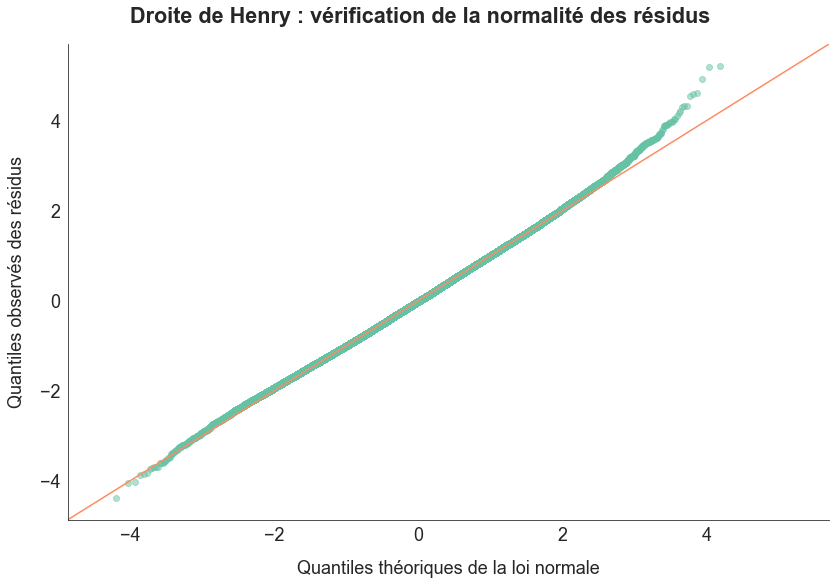

In [10]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

**Variation à 2 mois**

In [11]:
data_model = echant_alea_data42[["somme_signaux","variation_42_standard"]].copy()
len(data_model)

71679

In [12]:
anova = smf.ols(formula="variation_42_standard ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     1484.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          2.59e-321
Time:                           10:33:06   Log-Likelihood:                -40045.
No. Observations:                  71679   AIC:                         8.009e+04
Df Residuals:                      71677   BIC:                         8.011e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0673      0.002     39.870      0.000       0.064       0.071
somme_signaux     0.0002   5.85e-06     38.520      0.000       0.000       0.000
==============================================================================
Omnibus:                      135.974   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.729
Skew:                           0.107   Prob(JB):                     2.04e-30
Kurtosis:                       2.993   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
somme_signaux,265.556996,1.0,1483.765719,2.593845e-321,0.020281,0.020267
Residual,12828.392348,71677.0,NaN,NaN,NaN,NaN
total,13093.949344,71678.0,NaN,NaN,NaN,NaN


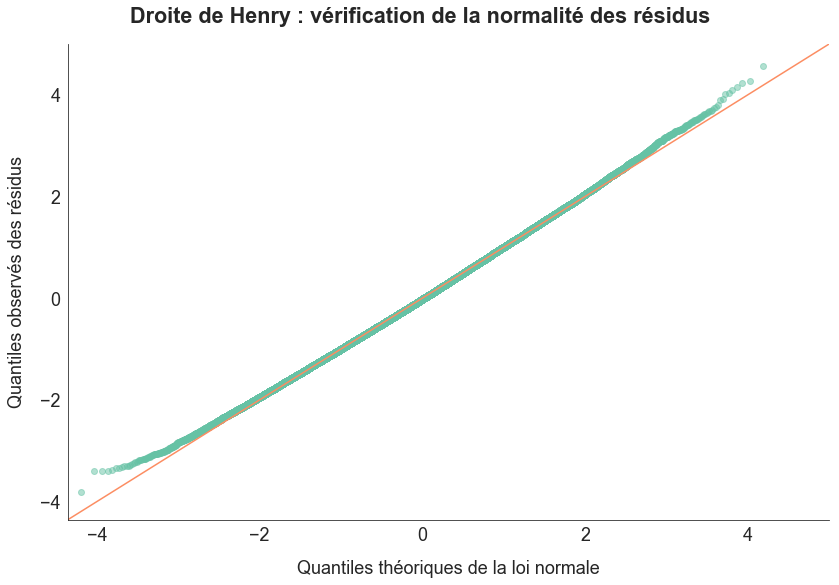

In [14]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

**Variation à 3 mois**

In [15]:
data_model = echant_alea_data64[["somme_signaux","variation_64_standard"]].copy()
len(data_model)

71455

In [16]:
anova = smf.ols(formula="variation_64_standard ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     1605.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:07   Log-Likelihood:                -55134.
No. Observations:                  71455   AIC:                         1.103e+05
Df Residuals:                      71453   BIC:                         1.103e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1015      0.002     48.478      0.000       0.097       0.106
somme_signaux     0.0003   7.27e-06     40.062      0.000       0.000       0.000
==============================================================================
Omnibus:                      270.791   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.727
Skew:                           0.151   Prob(JB):                     3.64e-60
Kurtosis:                       2.970   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
somme_signaux,439.738741,1.0,1604.970277,0.0,0.021968,0.021954
Residual,19577.092932,71453.0,NaN,NaN,NaN,NaN
total,20016.831673,71454.0,NaN,NaN,NaN,NaN


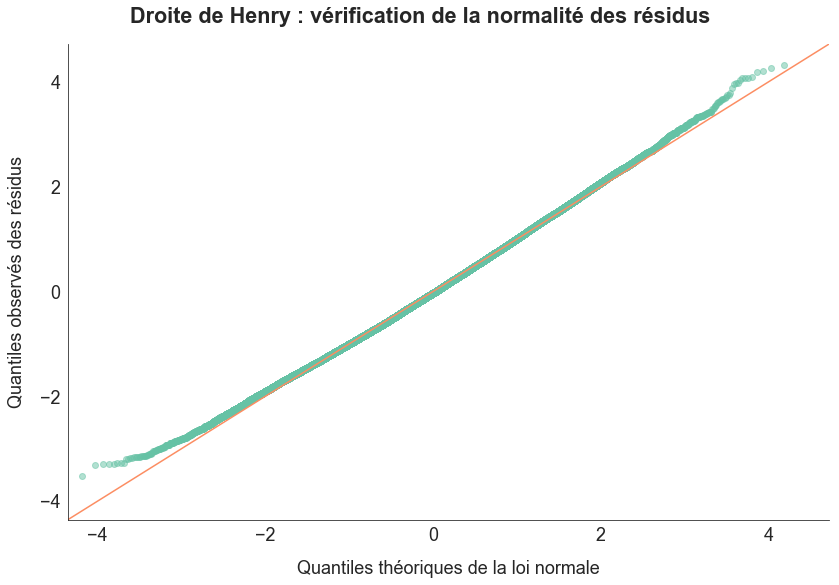

In [18]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

La somme globale des signaux ne permet pas d'anticiper la variation future des prix, que ce soit à 1 mois, 2 mois ou 3 mois. L'aspect intéressant est la bonne normalité des résidus.

### 3.2.2. Modélisation basée sur la somme des signaux par indicateur

Je commence toujours en étudiant le modèle sans interaction.
Puis j'inclus l'interraction entre les différents indicateurs pour voir un éventuel effet. Attention, cette interaction peut introduire des problèmes de colinéarité. Je dois vérifier cet élément avant d'analyser les résultats.  
J'ai remarqué que l'indicateur FOT se déclenche différemment des deux autres indicateurs. Il y a peut-être une information à tirer de cette différence, notamment via l'interaction avec les 2 autres indicateurs.

**Variation à 1 mois**

In [19]:
data_model = echant_alea_data21[["BRO","FOT","MOM","variation_21_standard"]].copy()
len(data_model)

71893

In [20]:
anova = smf.ols(formula="variation_21_standard ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.018
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     441.5
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          2.73e-284
Time:                           10:33:08   Log-Likelihood:                -16418.
No. Observations:                  71893   AIC:                         3.284e+04
Df Residuals:                      71889   BIC:                         3.288e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0341      0.001     27.669      0.000       0.032       0.037
BRO        -7.914e-05   3.47e-05     -2.279      0.023      -0.000   -1.11e-05
FOT            0.0006   4.09e-05     14.476      0.000       0.001       0.001
MOM         4.945e-05   3.55e-05      1.392      0.164   -2.02e-05       0.000
==============================================================================
Omnibus:                      166.882   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.441
Skew:                           0.111   Prob(JB):                     1.61e-37
Kurtosis:                       3.087   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
anova = smf.ols(formula="variation_21_standard ~ BRO + FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.018
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     661.3
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          2.48e-285
Time:                           10:33:08   Log-Likelihood:                -16419.
No. Observations:                  71893   AIC:                         3.284e+04
Df Residuals:                      71890   BIC:                         3.287e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0341      0.001     27.634      0.000       0.032       0.036
BRO        -4.931e-05   2.73e-05     -1.804      0.071      -0.000    4.26e-06
FOT            0.0006   3.78e-05     16.212      0.000       0.001       0.001
==============================================================================
Omnibus:                      166.514   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.047
Skew:                           0.111   Prob(JB):                     1.96e-37
Kurtosis:                       3.086   Cond. No.                         146.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
anova = smf.ols(formula="variation_21_standard ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.018
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     1319.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          2.77e-286
Time:                           10:33:08   Log-Likelihood:                -16420.
No. Observations:                  71893   AIC:                         3.284e+04
Df Residuals:                      71891   BIC:                         3.286e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0342      0.001     27.845      0.000       0.032       0.037
FOT            0.0006   1.52e-05     36.323      0.000       0.001       0.001
==============================================================================
Omnibus:                      166.246   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.786
Skew:                           0.110   Prob(JB):                     2.23e-37
Kurtosis:                       3.087   Cond. No.                         87.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Sans interaction, j'aboutis à ne garder que la somme des signaux pour FOT comme exogène. Avec un seul paramètre explicatif, je ne peux pas avoir de problème de colinéarité. Toutefois, les résultats ne sont pas suffisants pour garder cette modélisation et pousser plus avant son analyse.

In [23]:
anova = smf.ols(formula="variation_21_standard ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     194.1
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.65e-286
Time:                           10:33:08   Log-Likelihood:                -16401.
No. Observations:                  71893   AIC:                         3.282e+04
Df Residuals:                      71885   BIC:                         3.289e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0360      0.002     19.665      0.000       0.032       0.040
BRO         -8.911e-05   3.61e-05     -2.470      0.014      -0.000   -1.84e-05
FOT             0.0007   4.77e-05     14.886      0.000       0.001       0.001
BRO:FOT      1.758e-07   5.76e-07      0.305      0.760   -9.53e-07     1.3e-06
MOM             0.0001   3.89e-05      2.986      0.003    3.99e-05       0.000
BRO:MOM        3.3e-07   3.24e-07      1.017      0.309   -3.06e-07    9.66e-07
FOT:MOM     -9.504e-07   6.06e-07     -1.568      0.117   -2.14e-06    2.37e-07
BRO:FOT:MOM -9.773e-09   2.26e-09     -4.319      0.000   -1.42e-08   -5.34e-09
==============================================================================
Omnibus:                      167.928   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.629
Skew:                           0.111   Prob(JB):                     8.88e-38
Kurtosis:                       3.089   Cond. No.                     2.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

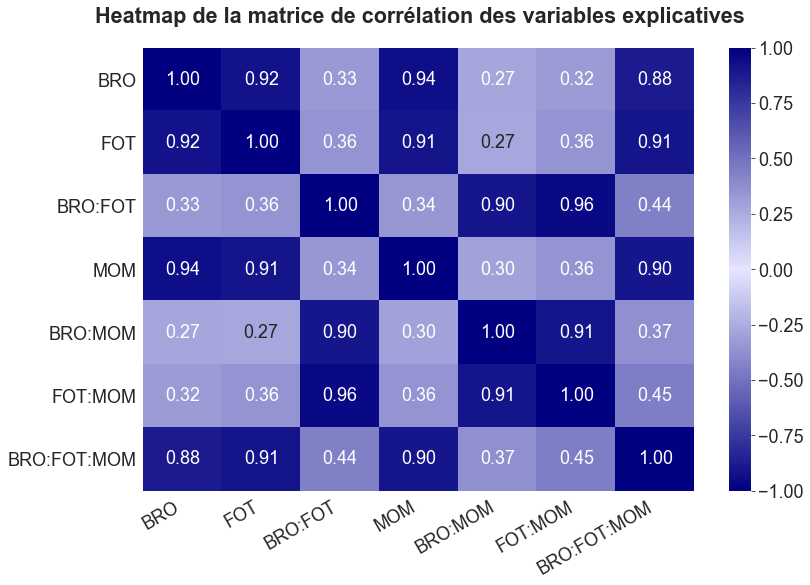

In [24]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

Il y a une forte multicolinéarité simple entre chacun des 3 indicateurs et leur interaction globale. Il y a également une forte multicolinéarité simple entre les interactions de 1er niveau (deux par deux).  
Pour prendre en compte la particularité de FOT, je ne conserve que FOT et l'interaction de 1er niveau qui lui est le moins corrélée, à savoir l'interaction entre les deux autres indicateurs BRO:MOM. Cela permet d'utiliser les 3 indicateurs et de ne plus avoir de problème de colinéarité simple.

In [25]:
anova = smf.ols(formula="variation_21_standard ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.018
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     664.0
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.75e-286
Time:                           10:33:08   Log-Likelihood:                -16416.
No. Observations:                  71893   AIC:                         3.284e+04
Df Residuals:                      71890   BIC:                         3.287e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0379      0.002     21.649      0.000       0.034       0.041
FOT            0.0006   1.57e-05     35.796      0.000       0.001       0.001
BRO:MOM    -3.728e-07   1.27e-07     -2.925      0.003   -6.23e-07   -1.23e-07
==============================================================================
Omnibus:                      164.892   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.420
Skew:                           0.110   Prob(JB):                     4.42e-37
Kurtosis:                       3.087   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

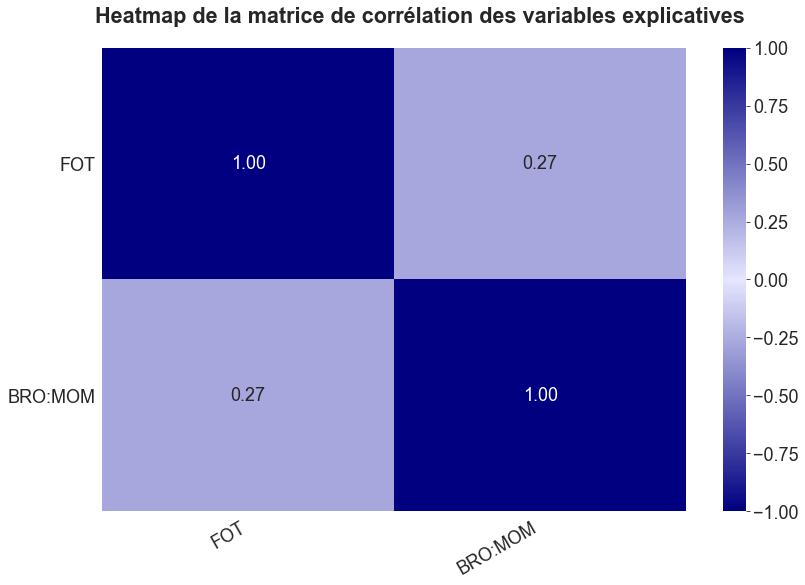

In [26]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [27]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.076055
BRO:MOM,1.076055


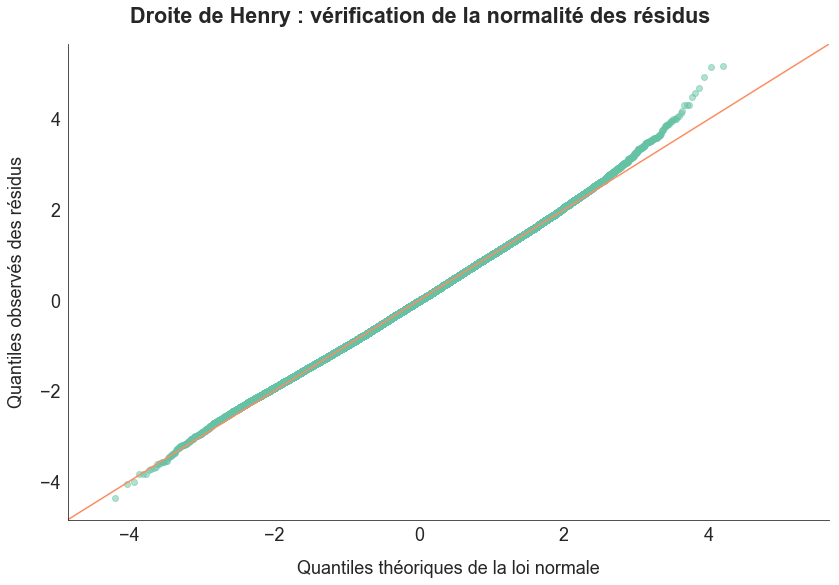

In [28]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Le modèle n'est pas satisfaisant (R² bien trop faible).

**Variation à 2 mois**

In [29]:
data_model = echant_alea_data42[["BRO","FOT","MOM","variation_42_standard"]].copy()
len(data_model)

71679

In [30]:
anova = smf.ols(formula="variation_42_standard ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     541.3
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:10   Log-Likelihood:                -39976.
No. Observations:                  71679   AIC:                         7.996e+04
Df Residuals:                      71675   BIC:                         8.000e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0636      0.002     37.057      0.000       0.060       0.067
BRO        -1.358e-05   4.83e-05     -0.281      0.779      -0.000    8.11e-05
FOT            0.0009   5.67e-05     15.633      0.000       0.001       0.001
MOM        -1.679e-05   4.98e-05     -0.337      0.736      -0.000    8.08e-05
==============================================================================
Omnibus:                      138.241   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.014
Skew:                           0.108   Prob(JB):                     6.51e-31
Kurtosis:                       2.983   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
anova = smf.ols(formula="variation_42_standard ~ FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     812.0
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:10   Log-Likelihood:                -39976.
No. Observations:                  71679   AIC:                         7.996e+04
Df Residuals:                      71676   BIC:                         7.999e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0636      0.002     37.081      0.000       0.060       0.067
FOT            0.0009   5.13e-05     17.137      0.000       0.001       0.001
MOM        -2.549e-05    3.9e-05     -0.653      0.513      -0.000     5.1e-05
==============================================================================
Omnibus:                      138.103   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.875
Skew:                           0.108   Prob(JB):                     6.98e-31
Kurtosis:                       2.983   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
anova = smf.ols(formula="variation_42_standard ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     1624.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:10   Log-Likelihood:                -39977.
No. Observations:                  71679   AIC:                         7.996e+04
Df Residuals:                      71677   BIC:                         7.998e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0637      0.002     37.246      0.000       0.060       0.067
FOT            0.0008   2.11e-05     40.293      0.000       0.001       0.001
==============================================================================
Omnibus:                      138.283   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.058
Skew:                           0.108   Prob(JB):                     6.37e-31
Kurtosis:                       2.984   Cond. No.                         87.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
anova = smf.ols(formula="variation_42_standard ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.023
Model:                               OLS   Adj. R-squared:                  0.023
Method:                    Least Squares   F-statistic:                     242.3
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:10   Log-Likelihood:                -39941.
No. Observations:                  71679   AIC:                         7.990e+04
Df Residuals:                      71671   BIC:                         7.997e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0682      0.003     26.749      0.000       0.063       0.073
BRO         -6.511e-05   5.02e-05     -1.296      0.195      -0.000    3.33e-05
FOT             0.0010   6.62e-05     15.798      0.000       0.001       0.001
BRO:FOT       3.26e-06   8.06e-07      4.046      0.000    1.68e-06    4.84e-06
MOM             0.0001   5.45e-05      2.752      0.006    4.31e-05       0.000
BRO:MOM     -3.797e-07    4.5e-07     -0.844      0.399   -1.26e-06    5.02e-07
FOT:MOM       -3.6e-06   8.46e-07     -4.257      0.000   -5.26e-06   -1.94e-06
BRO:FOT:MOM -1.551e-08   3.15e-09     -4.916      0.000   -2.17e-08   -9.33e-09
==============================================================================
Omnibus:                      134.143   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.877
Skew:                           0.106   Prob(JB):                     5.15e-30
Kurtosis:                       2.987   Cond. No.                     2.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

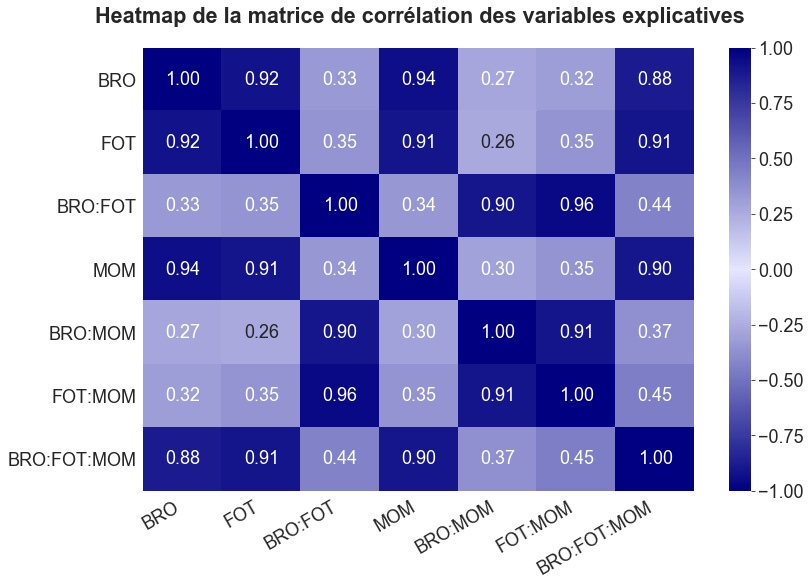

In [34]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [35]:
anova = smf.ols(formula="variation_42_standard ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     824.6
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:10   Log-Likelihood:                -39964.
No. Observations:                  71679   AIC:                         7.993e+04
Df Residuals:                      71676   BIC:                         7.996e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0724      0.002     29.711      0.000       0.068       0.077
FOT            0.0009   2.19e-05     40.191      0.000       0.001       0.001
BRO:MOM    -8.877e-07   1.77e-07     -5.011      0.000   -1.23e-06   -5.41e-07
==============================================================================
Omnibus:                      131.938   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.643
Skew:                           0.105   Prob(JB):                     1.57e-29
Kurtosis:                       2.984   Cond. No.                     2.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

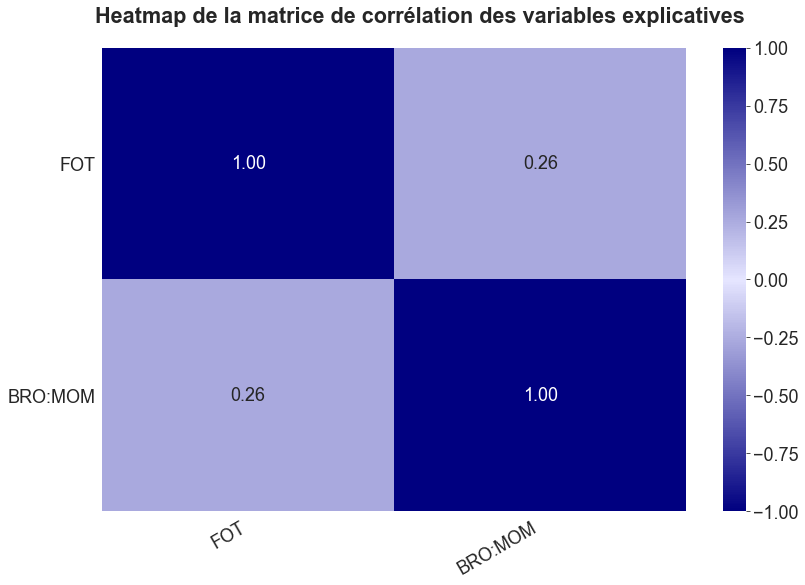

In [36]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [37]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.075124
BRO:MOM,1.075124


Le modèle n'est pas plus satisfaisant pour expliquer la variation à 2 mois.

**Variation à 3 mois**

In [38]:
data_model = echant_alea_data64[["BRO","FOT","MOM","variation_64_standard"]].copy()
len(data_model)

71455

In [39]:
anova = smf.ols(formula="variation_64_standard ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.025
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     600.6
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:11   Log-Likelihood:                -55037.
No. Observations:                  71455   AIC:                         1.101e+05
Df Residuals:                      71451   BIC:                         1.101e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0960      0.002     45.124      0.000       0.092       0.100
BRO         2.905e-05      6e-05      0.484      0.628   -8.85e-05       0.000
FOT            0.0013   7.03e-05     17.814      0.000       0.001       0.001
MOM           -0.0002   6.17e-05     -2.435      0.015      -0.000   -2.93e-05
==============================================================================
Omnibus:                      273.359   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.219
Skew:                           0.151   Prob(JB):                     1.05e-60
Kurtosis:                       2.961   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
anova = smf.ols(formula="variation_64_standard ~ FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.025
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     900.8
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:11   Log-Likelihood:                -55038.
No. Observations:                  71455   AIC:                         1.101e+05
Df Residuals:                      71452   BIC:                         1.101e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0960      0.002     45.134      0.000       0.092       0.100
FOT            0.0013   6.36e-05     19.928      0.000       0.001       0.001
MOM           -0.0001   4.83e-05     -2.725      0.006      -0.000    -3.7e-05
==============================================================================
Omnibus:                      273.776   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.641
Skew:                           0.151   Prob(JB):                     8.48e-61
Kurtosis:                       2.961   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

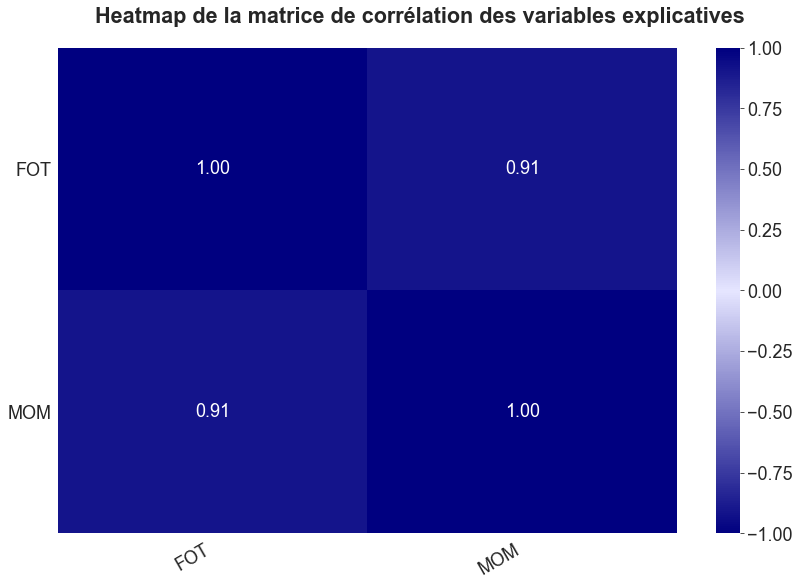

In [41]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [42]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
FOT,108.517983,1.0,397.132684,4.027993e-88,0.005527,0.005513
MOM,2.029617,1.0,7.427590,6.424694e-03,0.000103,0.000089
Residual,19524.524837,71452.0,NaN,NaN,NaN,NaN
total,19635.072437,71454.0,NaN,NaN,NaN,NaN


La p-value indique que je peux garder à  la fois FOT et MOM pour modéliser la variation du prix à 3 mois. Cependant, j'ai un problème de colinéarité simple entre ces deux variables. Du fait, de sa p-value inférieure et de son omega_squared bien supérieur, je ne garde que FOT comme variable explicative.

In [43]:
anova = smf.ols(formula="variation_64_standard ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.024
Model:                               OLS   Adj. R-squared:                  0.024
Method:                    Least Squares   F-statistic:                     1794.
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:11   Log-Likelihood:                -55041.
No. Observations:                  71455   AIC:                         1.101e+05
Df Residuals:                      71453   BIC:                         1.101e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0964      0.002     45.473      0.000       0.092       0.101
FOT            0.0011   2.62e-05     42.356      0.000       0.001       0.001
==============================================================================
Omnibus:                      275.800   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.731
Skew:                           0.152   Prob(JB):                     2.98e-61
Kurtosis:                       2.962   Cond. No.                         87.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
anova = smf.ols(formula="variation_64_standard ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.026
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     267.3
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:12   Log-Likelihood:                -55004.
No. Observations:                  71455   AIC:                         1.100e+05
Df Residuals:                      71447   BIC:                         1.101e+05
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1095      0.003     34.671      0.000       0.103       0.116
BRO          1.605e-05   6.27e-05      0.256      0.798      -0.000       0.000
FOT             0.0014    8.2e-05     16.482      0.000       0.001       0.002
BRO:FOT      1.588e-06   9.94e-07      1.598      0.110    -3.6e-07    3.54e-06
MOM         -7.765e-06   6.78e-05     -0.115      0.909      -0.000       0.000
BRO:MOM     -1.796e-06   5.57e-07     -3.221      0.001   -2.89e-06   -7.03e-07
FOT:MOM     -1.063e-06   1.05e-06     -1.015      0.310   -3.12e-06     9.9e-07
BRO:FOT:MOM -1.219e-08   3.92e-09     -3.112      0.002   -1.99e-08   -4.51e-09
==============================================================================
Omnibus:                      256.711   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.226
Skew:                           0.146   Prob(JB):                     5.13e-57
Kurtosis:                       2.962   Cond. No.                     2.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

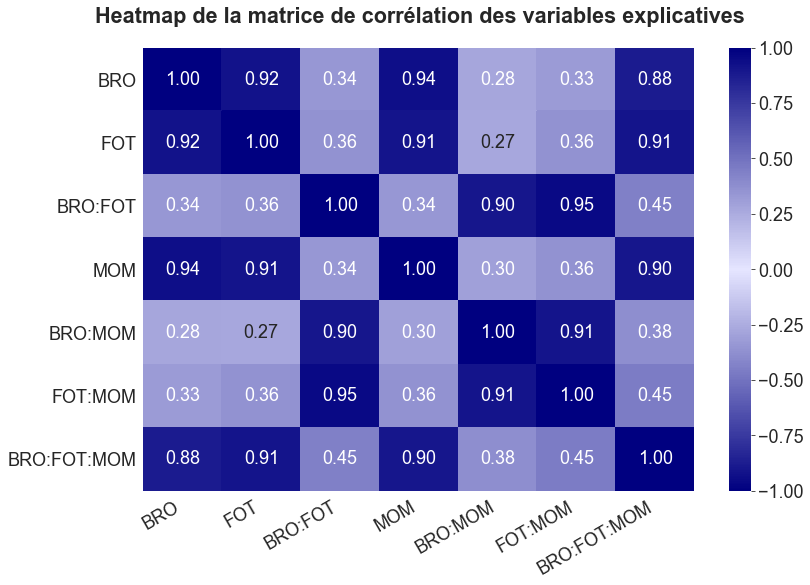

In [45]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [46]:
anova = smf.ols(formula="variation_64_standard ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.025
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     927.9
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:12   Log-Likelihood:                -55011.
No. Observations:                  71455   AIC:                         1.100e+05
Df Residuals:                      71452   BIC:                         1.101e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1130      0.003     37.523      0.000       0.107       0.119
FOT            0.0012   2.72e-05     42.897      0.000       0.001       0.001
BRO:MOM    -1.708e-06    2.2e-07     -7.762      0.000   -2.14e-06   -1.28e-06
==============================================================================
Omnibus:                      257.172   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.690
Skew:                           0.146   Prob(JB):                     4.07e-57
Kurtosis:                       2.961   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

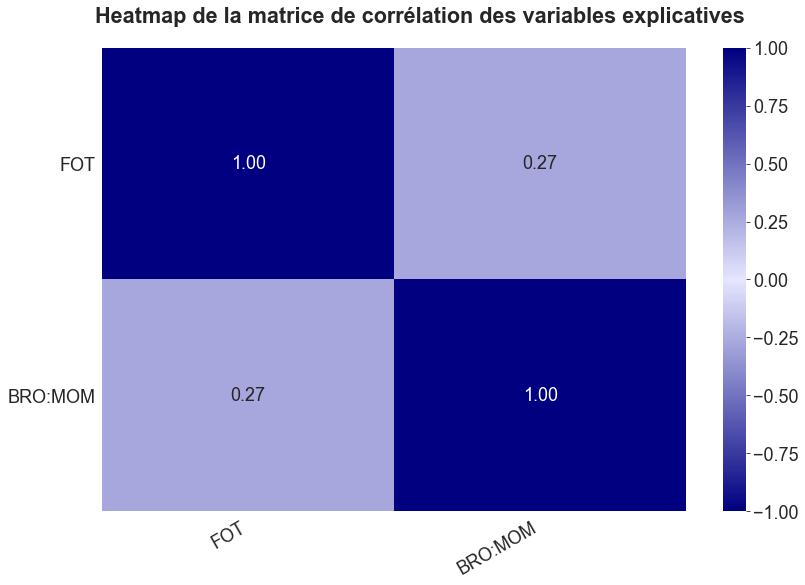

In [47]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [48]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.07845
BRO:MOM,1.07845


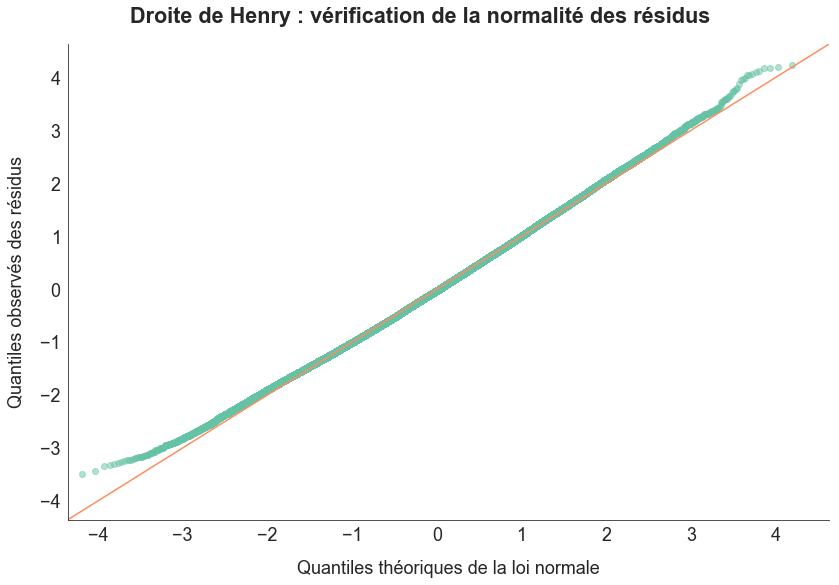

In [49]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Aucun modèle étudié jusqu'à présent n'est intéressant pour modéliser la variation future des prix, que ce soit à 1 mois, 2 mois ou 3 mois.

### 3.2.3. Modélisation basée sur la somme des signaux par indicateur avec FOT comme trigger

J'ai remarqué que FOT atteint plus difficilement des sommes extrêmes. On peut se dire que lorsque la somme des signaux sur FOT passe au-dessus de 100 ou au-dessous de -100, c'est un signal que les marchés risquent de se retourner. Nous allons donc ajouter une colonne trigger_FOT qui est égale à 0 si la somme des signaux sur FOT est comprise entre -100 et +100; 1 sinon.

In [50]:
echant_alea_data21["trigger_FOT"] = (echant_alea_data21.FOT > 100) | (echant_alea_data21.FOT <- 100)
echant_alea_data21.trigger_FOT = echant_alea_data21.trigger_FOT.astype('int')
echant_alea_data21.head()

,contract_id,dateref,category_name,somme_signaux,variation_21_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil,trigger_FOT
0,9,2015-07-22,LTIR,165,4.013552e-01,8,False,69,31,65,...,-2,25,25,25,-10,0,0,True,True,0
1,91,2009-06-29,Metals,30,5.976307e-02,2,False,7,23,0,...,14,-25,-25,-25,25,25,25,True,False,0
2,32,2009-08-14,STIR,416,5.403889e-01,0,True,150,116,150,...,20,25,25,25,25,25,25,True,True,1
3,6,2010-02-26,Currencies,67,-4.207197e-01,6,False,59,-6,14,...,-2,25,25,11,-25,-25,3,True,True,0
4,37,2011-08-18,STIR,432,-3.030987e-13,1,False,150,132,150,...,17,25,25,25,25,25,25,False,False,1


In [51]:
echant_alea_data42["trigger_FOT"] = (echant_alea_data42.FOT > 100) | (echant_alea_data42.FOT <- 100)
echant_alea_data42.trigger_FOT = echant_alea_data42.trigger_FOT.astype('int')
echant_alea_data42.head()

,contract_id,dateref,category_name,somme_signaux,variation_42_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil,trigger_FOT
0,13,2013-12-26,LTIR,136,0.492840,6,False,29,39,68,...,11,-3,-4,0,25,25,25,False,True,0
1,12,1991-05-03,LTIR,0,-0.069842,0,False,0,0,0,...,0,0,0,0,0,0,0,True,False,0
2,15,1991-01-04,LTIR,0,-0.144532,0,False,0,0,0,...,0,0,0,0,0,0,0,True,False,0
3,23,2001-06-22,Energy,-200,-0.368365,9,False,-54,-99,-47,...,-25,18,7,3,-25,-25,-25,True,True,0
4,26,2006-06-15,Energy,343,0.362887,8,False,146,59,138,...,15,25,25,25,25,25,13,True,True,0


In [52]:
echant_alea_data64["trigger_FOT"] = (echant_alea_data64.FOT > 100) | (echant_alea_data64.FOT <- 100)
echant_alea_data64.trigger_FOT = echant_alea_data64.trigger_FOT.astype('int')
echant_alea_data64.head()

,contract_id,dateref,category_name,somme_signaux,variation_64_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil,trigger_FOT
0,44,2002-05-16,Index,-59,-0.655845,8,False,0,-20,-39,...,2,-25,-25,-25,25,-2,13,False,True,0
1,25,2009-03-31,Energy,-380,0.694890,9,False,-150,-109,-121,...,-25,-25,-14,-7,-25,-25,-25,True,True,1
2,59,1990-06-11,Index,0,-0.621847,8,False,0,0,0,...,0,0,0,0,0,0,0,False,True,0
3,25,1993-05-11,Energy,18,-0.861281,8,False,12,30,-24,...,10,-25,-25,-25,25,25,1,False,True,0
4,33,1997-09-15,STIR,424,0.346597,0,False,150,124,150,...,24,25,25,25,25,25,25,True,False,1


**Variation à 1 mois**

In [53]:
data_model = echant_alea_data21[["BRO","trigger_FOT","MOM","variation_21_standard"]].copy()
len(data_model)

71893

In [54]:
anova = smf.ols(formula="variation_21_standard ~ BRO + trigger_FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     371.5
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.73e-239
Time:                           10:33:13   Log-Likelihood:                -16521.
No. Observations:                  71893   AIC:                         3.305e+04
Df Residuals:                      71889   BIC:                         3.309e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0391      0.001     28.863      0.000       0.036       0.042
BRO             0.0001   3.13e-05      4.436      0.000    7.76e-05       0.000
trigger_FOT    -0.0044      0.003     -1.659      0.097      -0.010       0.001
MOM             0.0003   3.31e-05      7.558      0.000       0.000       0.000
==============================================================================
Omnibus:                      167.096   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.215
Skew:                           0.109   Prob(JB):                     1.09e-37
Kurtosis:                       3.096   Cond. No.                         360.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

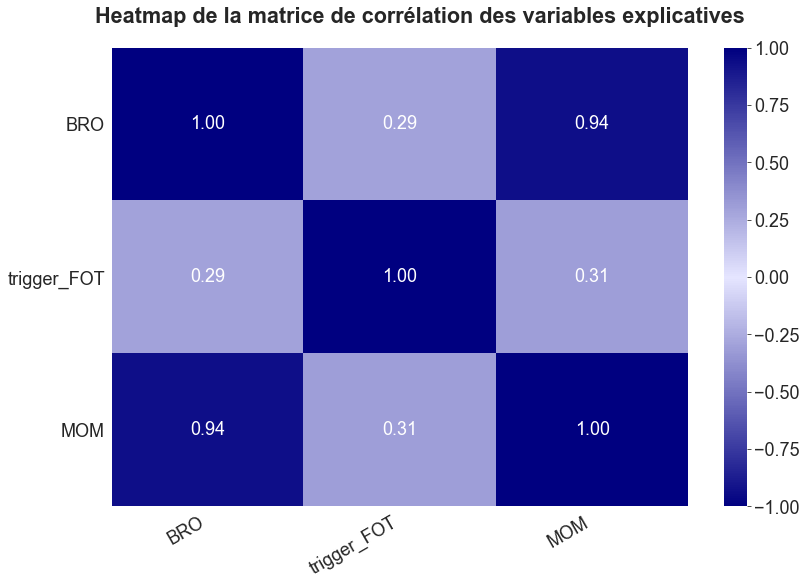

In [55]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [56]:
anova = smf.ols(formula="variation_21_standard ~ BRO + trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.014
Model:                               OLS   Adj. R-squared:                  0.014
Method:                    Least Squares   F-statistic:                     528.3
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.63e-228
Time:                           10:33:14   Log-Likelihood:                -16550.
No. Observations:                  71893   AIC:                         3.311e+04
Df Residuals:                      71890   BIC:                         3.313e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0390      0.001     28.777      0.000       0.036       0.042
BRO             0.0004   1.15e-05     31.316      0.000       0.000       0.000
trigger_FOT    -0.0022      0.003     -0.837      0.403      -0.007       0.003
==============================================================================
Omnibus:                      164.834   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.905
Skew:                           0.108   Prob(JB):                     3.47e-37
Kurtosis:                       3.096   Cond. No.                         263.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ce modèle m'amène à ne sélectionner que l'indicateur BRO, qui est une moins bonne solution que l'indicateur FOT seul. Je regarde ce que donne le modèle avec interaction.

In [57]:
anova = smf.ols(formula="variation_21_standard ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.016
Model:                               OLS   Adj. R-squared:                  0.016
Method:                    Least Squares   F-statistic:                     167.7
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          3.28e-247
Time:                           10:33:14   Log-Likelihood:                -16492.
No. Observations:                  71893   AIC:                         3.300e+04
Df Residuals:                      71885   BIC:                         3.307e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0400      0.002     22.123      0.000       0.036       0.044
BRO                     0.0001   3.27e-05      4.136      0.000    7.11e-05       0.000
trigger_FOT             0.0390      0.009      4.331      0.000       0.021       0.057
BRO:trigger_FOT        -0.0001      0.000     -0.926      0.355      -0.000       0.000
MOM                     0.0002   3.54e-05      5.824      0.000       0.000       0.000
BRO:MOM             -2.144e-08   1.69e-07     -0.127      0.899   -3.53e-07    3.11e-07
trigger_FOT:MOM         0.0002      0.000      1.982      0.047    2.68e-06       0.000
BRO:trigger_FOT:MOM -2.553e-06   4.65e-07     -5.486      0.000   -3.46e-06   -1.64e-06
==============================================================================
Omnibus:                      165.056   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.991
Skew:                           0.109   Prob(JB):                     3.32e-37
Kurtosis:                       3.094   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

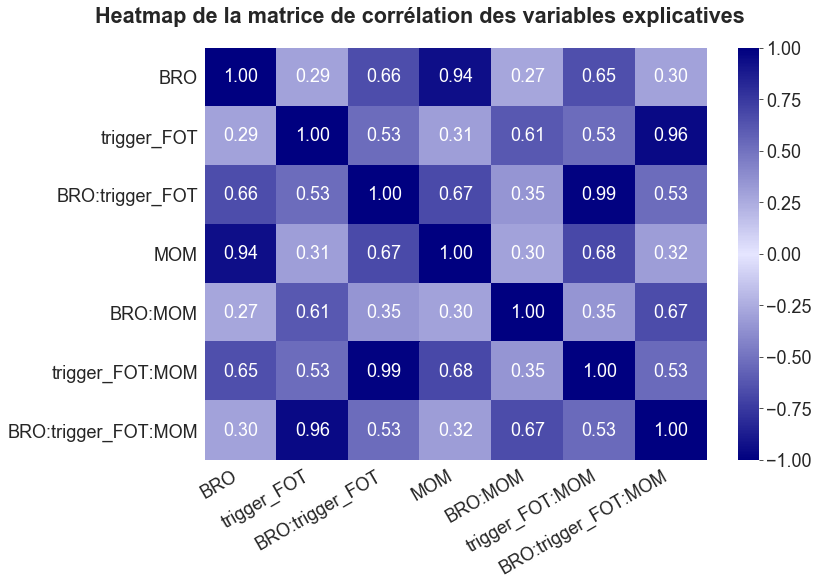

In [58]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

L'analyse de la multicolinéarité simple nous conduit à garder BRO et trigger_FOT en prenant en compte leur interaction, et à n'introduire MOM qu'à travers son interaction avec BRO.

In [59]:
anova = smf.ols(formula="variation_21_standard ~ BRO + trigger_FOT + BRO:trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     273.9
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          3.91e-234
Time:                           10:33:15   Log-Likelihood:                -16530.
No. Observations:                  71893   AIC:                         3.307e+04
Df Residuals:                      71888   BIC:                         3.312e+04
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0419      0.002     23.852      0.000       0.038       0.045
BRO                 0.0003   1.47e-05     20.950      0.000       0.000       0.000
trigger_FOT        -0.0071      0.004     -1.988      0.047      -0.014   -9.83e-05
BRO:trigger_FOT     0.0001   2.36e-05      5.853      0.000     9.2e-05       0.000
BRO:MOM         -2.722e-07   1.57e-07     -1.730      0.084   -5.81e-07    3.61e-08
==============================================================================
Omnibus:                      163.061   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.928
Skew:                           0.108   Prob(JB):                     9.31e-37
Kurtosis:                       3.093   Cond. No.                     4.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Le coefficient de l'interaction entre BRO et MOM n'est pas significatif. Je retire cette interaction.

In [60]:
anova = smf.ols(formula="variation_21_standard ~ BRO * trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     364.2
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          8.40e-235
Time:                           10:33:15   Log-Likelihood:                -16532.
No. Observations:                  71893   AIC:                         3.307e+04
Df Residuals:                      71889   BIC:                         3.311e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0400      0.001     29.277      0.000       0.037       0.043
BRO                 0.0003   1.46e-05     20.905      0.000       0.000       0.000
trigger_FOT        -0.0105      0.003     -3.515      0.000      -0.016      -0.005
BRO:trigger_FOT     0.0001   2.36e-05      5.959      0.000    9.44e-05       0.000
==============================================================================
Omnibus:                      164.454   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.348
Skew:                           0.109   Prob(JB):                     4.58e-37
Kurtosis:                       3.093   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

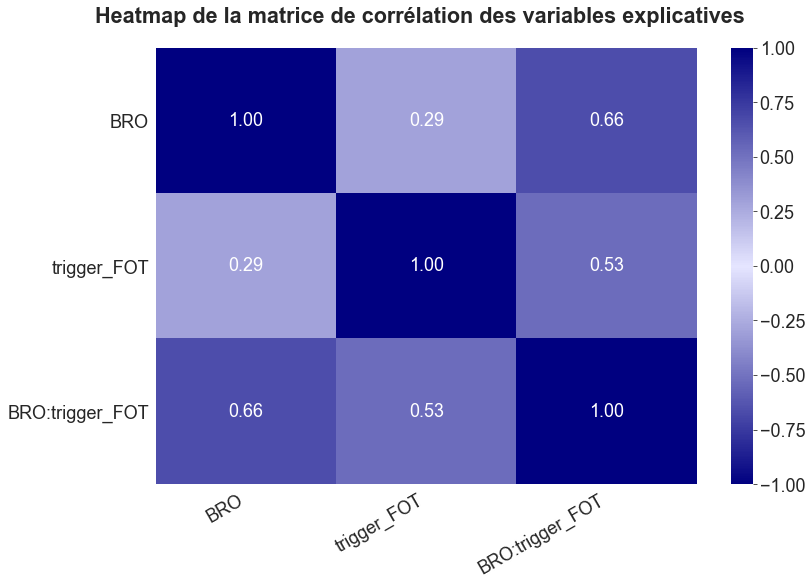

In [61]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [62]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
BRO,1.774181
trigger_FOT,1.396616
BRO:trigger_FOT,2.248943


In [63]:
table_anova = sm.stats.anova_lm(anova, typ=3)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
Intercept,79.492263,1.0,857.123347,2.608125e-187,0.011704,0.011690
BRO,40.530570,1.0,437.019862,9.367868e-97,0.005968,0.005954
trigger_FOT,1.145912,1.0,12.355770,4.398958e-04,0.000169,0.000155
BRO:trigger_FOT,3.293393,1.0,35.510924,2.548007e-09,0.000485,0.000471
Residual,6667.207622,71889.0,NaN,NaN,NaN,NaN
total,6791.669760,71893.0,NaN,NaN,NaN,NaN


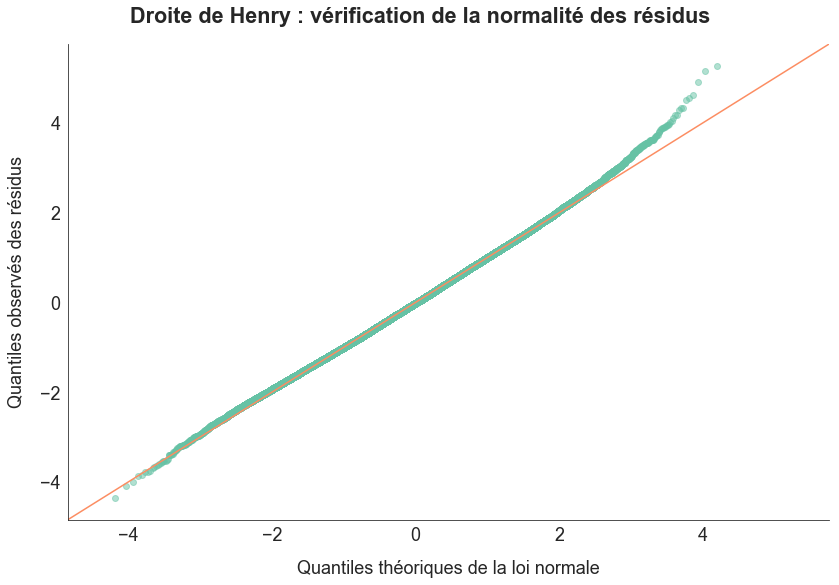

In [64]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Le modèle n'est pas satisfaisant car très peu explicatif.

J'essaie le même modèle en utilisant maintenant le trigger_FOT comme une catégorie, ce qui est plus logique.

In [65]:
data_model = echant_alea_data21[["BRO","trigger_FOT","MOM","variation_21_standard"]].copy()
len(data_model)

71893

In [66]:
anova = smf.ols(formula="variation_21_standard ~ BRO * C(trigger_FOT)", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_21_standard   R-squared:                       0.015
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     364.2
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          8.40e-235
Time:                           10:33:16   Log-Likelihood:                -16532.
No. Observations:                  71893   AIC:                         3.307e+04
Df Residuals:                      71889   BIC:                         3.311e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0400      0.001     29.277      0.000       0.037       0.043
C(trigger_FOT)[T.1]        -0.0105      0.003     -3.515      0.000      -0.016      -0.005
BRO                         0.0003   1.46e-05     20.905      0.000       0.000       0.000
BRO:C(trigger_FOT)[T.1]     0.0001   2.36e-05      5.959      0.000    9.44e-05       0.000
==============================================================================
Omnibus:                      164.454   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.348
Skew:                           0.109   Prob(JB):                     4.58e-37
Kurtosis:                       3.093   Cond. No.                         335.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Je vois de suite que le résultat est similaire au résultat précédent et que la modélisation est mauvaise. Il ne sert à rien de chercher plus loin sur cette base.

**Variation à 2 mois**

In [67]:
data_model = echant_alea_data42[["BRO","trigger_FOT","MOM","variation_42_standard"]].copy()
len(data_model)

71679

In [68]:
anova = smf.ols(formula="variation_42_standard ~ BRO + trigger_FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.019
Method:                    Least Squares   F-statistic:                     462.4
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          1.31e-297
Time:                           10:33:16   Log-Likelihood:                -40092.
No. Observations:                  71679   AIC:                         8.019e+04
Df Residuals:                      71675   BIC:                         8.023e+04
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0725      0.002     38.396      0.000       0.069       0.076
BRO             0.0003   4.38e-05      7.011      0.000       0.000       0.000
trigger_FOT    -0.0128      0.004     -3.471      0.001      -0.020      -0.006
MOM             0.0003   4.63e-05      6.456      0.000       0.000       0.000
==============================================================================
Omnibus:                      132.682   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.395
Skew:                           0.106   Prob(JB):                     1.08e-29
Kurtosis:                       2.998   Cond. No.                         360.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

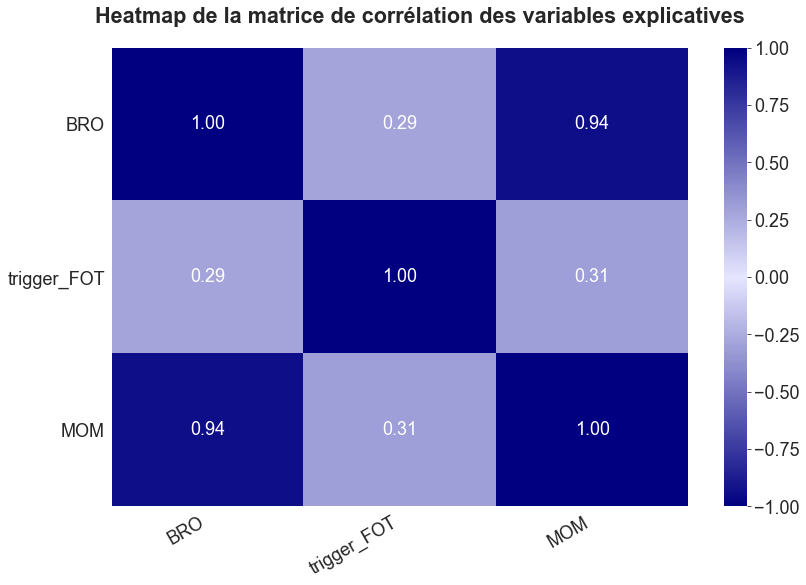

In [69]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [70]:
anova = smf.ols(formula="variation_42_standard ~ BRO + trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.018
Model:                               OLS   Adj. R-squared:                  0.018
Method:                    Least Squares   F-statistic:                     672.4
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          4.90e-290
Time:                           10:33:17   Log-Likelihood:                -40113.
No. Observations:                  71679   AIC:                         8.023e+04
Df Residuals:                      71676   BIC:                         8.026e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0723      0.002     38.311      0.000       0.069       0.076
BRO             0.0006   1.59e-05     35.822      0.000       0.001       0.001
trigger_FOT    -0.0101      0.004     -2.761      0.006      -0.017      -0.003
==============================================================================
Omnibus:                      128.642   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.310
Skew:                           0.104   Prob(JB):                     8.33e-29
Kurtosis:                       2.999   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
anova = smf.ols(formula="variation_42_standard ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     208.1
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          2.51e-307
Time:                           10:33:17   Log-Likelihood:                -40058.
No. Observations:                  71679   AIC:                         8.013e+04
Df Residuals:                      71671   BIC:                         8.021e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0752      0.003     29.879      0.000       0.070       0.080
BRO                     0.0003   4.56e-05      6.799      0.000       0.000       0.000
trigger_FOT             0.0590      0.013      4.693      0.000       0.034       0.084
BRO:trigger_FOT        -0.0002      0.000     -1.425      0.154      -0.001    8.82e-05
MOM                     0.0002   4.96e-05      4.852      0.000       0.000       0.000
BRO:MOM             -2.695e-07   2.35e-07     -1.148      0.251    -7.3e-07    1.91e-07
trigger_FOT:MOM         0.0004      0.000      2.353      0.019    6.65e-05       0.001
BRO:trigger_FOT:MOM -3.923e-06   6.48e-07     -6.051      0.000   -5.19e-06   -2.65e-06
==============================================================================
Omnibus:                      129.803   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.489
Skew:                           0.104   Prob(JB):                     4.62e-29
Kurtosis:                       2.993   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

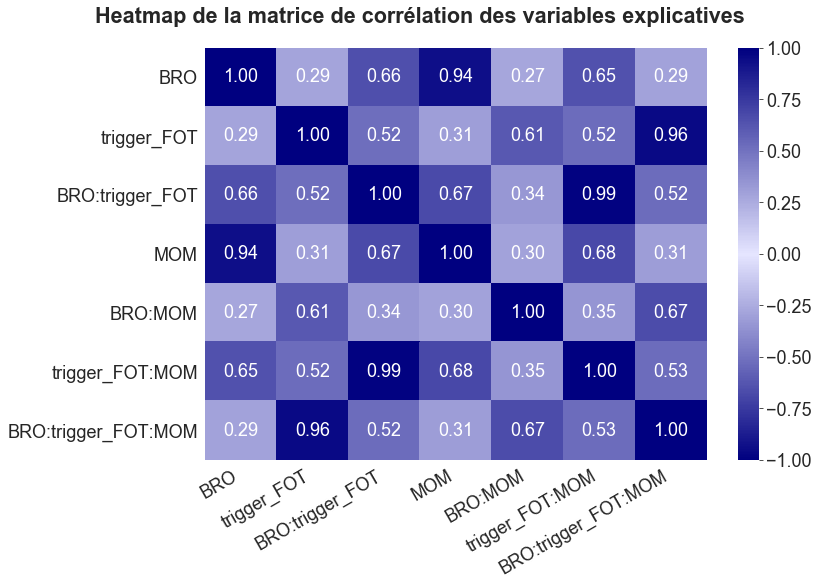

In [72]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [73]:
anova = smf.ols(formula="variation_42_standard ~ BRO * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_42_standard   R-squared:                       0.019
Model:                               OLS   Adj. R-squared:                  0.019
Method:                    Least Squares   F-statistic:                     345.5
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          3.80e-295
Time:                           10:33:18   Log-Likelihood:                -40095.
No. Observations:                  71679   AIC:                         8.020e+04
Df Residuals:                      71674   BIC:                         8.025e+04
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0783      0.002     32.012      0.000       0.073       0.083
BRO                 0.0005   2.05e-05     25.141      0.000       0.000       0.001
trigger_FOT        -0.0115      0.005     -2.331      0.020      -0.021      -0.002
BRO:trigger_FOT     0.0002   3.28e-05      4.983      0.000    9.92e-05       0.000
BRO:MOM         -6.844e-07   2.18e-07     -3.134      0.002   -1.11e-06   -2.56e-07
==============================================================================
Omnibus:                      125.891   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.534
Skew:                           0.103   Prob(JB):                     3.34e-28
Kurtosis:                       2.996   Cond. No.                     4.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

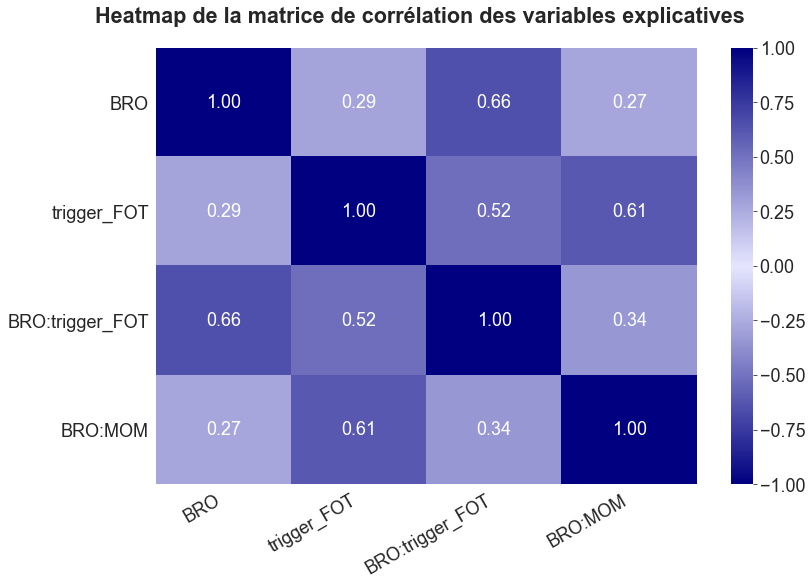

In [74]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [75]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
BRO,1.800243
trigger_FOT,1.981465
BRO:trigger_FOT,2.236435
BRO:MOM,1.628094


J'arrive à la même conclusion : la modélisation de la variation à 2 mois n'est pas intéressante car peu explicative.

**Variation à 3 mois**

In [76]:
data_model = echant_alea_data64[["BRO","trigger_FOT","MOM","variation_64_standard"]].copy()
len(data_model)

71455

In [77]:
anova = smf.ols(formula="variation_64_standard ~ BRO + trigger_FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     497.8
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          3.32e-320
Time:                           10:33:18   Log-Likelihood:                -55188.
No. Observations:                  71455   AIC:                         1.104e+05
Df Residuals:                      71451   BIC:                         1.104e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1085      0.002     46.492      0.000       0.104       0.113
BRO             0.0005   5.44e-05      8.932      0.000       0.000       0.001
trigger_FOT    -0.0179      0.005     -3.901      0.000      -0.027      -0.009
MOM             0.0003   5.76e-05      5.068      0.000       0.000       0.000
==============================================================================
Omnibus:                      261.619   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.406
Skew:                           0.149   Prob(JB):                     3.85e-58
Kurtosis:                       2.976   Cond. No.                         361.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

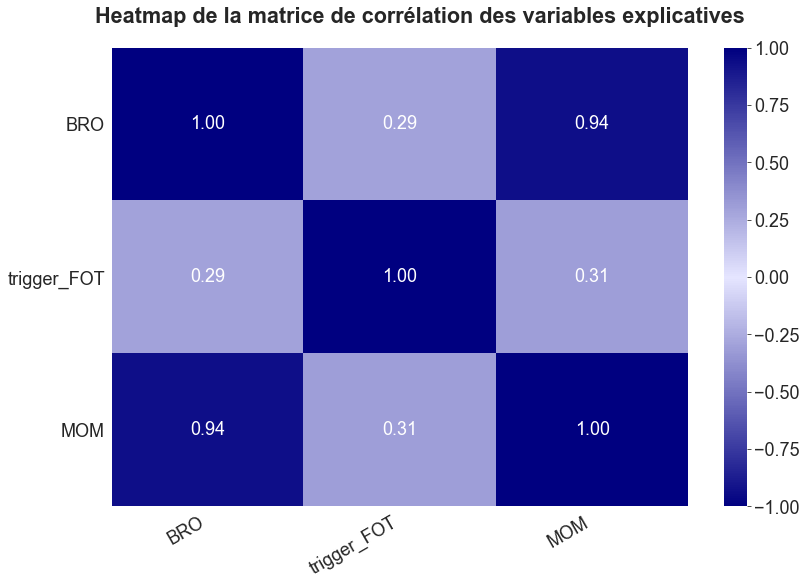

In [78]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [79]:
anova = smf.ols(formula="variation_64_standard ~ BRO + trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.020
Method:                    Least Squares   F-statistic:                     733.6
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):          4.06e-316
Time:                           10:33:19   Log-Likelihood:                -55201.
No. Observations:                  71455   AIC:                         1.104e+05
Df Residuals:                      71452   BIC:                         1.104e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1084      0.002     46.455      0.000       0.104       0.113
BRO             0.0007   1.98e-05     37.488      0.000       0.001       0.001
trigger_FOT    -0.0153      0.005     -3.357      0.001      -0.024      -0.006
==============================================================================
Omnibus:                      255.035   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.691
Skew:                           0.147   Prob(JB):                     1.10e-56
Kurtosis:                       2.978   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
anova = smf.ols(formula="variation_64_standard ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.023
Model:                               OLS   Adj. R-squared:                  0.022
Method:                    Least Squares   F-statistic:                     235.4
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:19   Log-Likelihood:                -55113.
No. Observations:                  71455   AIC:                         1.102e+05
Df Residuals:                      71447   BIC:                         1.103e+05
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1171      0.003     37.606      0.000       0.111       0.123
BRO                     0.0005   5.67e-05      9.335      0.000       0.000       0.001
trigger_FOT             0.0830      0.016      5.316      0.000       0.052       0.114
BRO:trigger_FOT        -0.0009      0.000     -4.329      0.000      -0.001      -0.000
MOM                     0.0001   6.16e-05      2.272      0.023    1.92e-05       0.000
BRO:MOM             -9.644e-07   2.91e-07     -3.312      0.001   -1.54e-06   -3.94e-07
trigger_FOT:MOM         0.0012      0.000      5.807      0.000       0.001       0.002
BRO:trigger_FOT:MOM  -5.43e-06   8.06e-07     -6.739      0.000   -7.01e-06   -3.85e-06
==============================================================================
Omnibus:                      245.318   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.681
Skew:                           0.143   Prob(JB):                     1.65e-54
Kurtosis:                       2.968   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

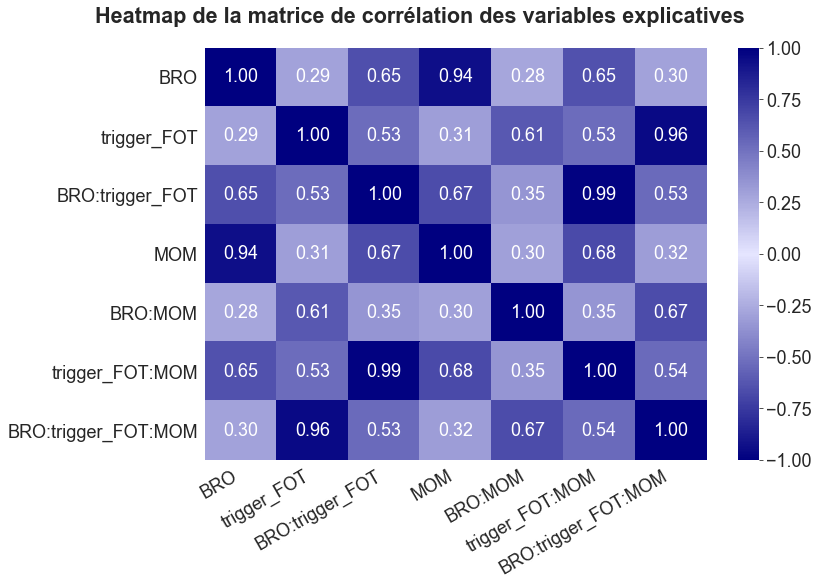

In [81]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [82]:
anova = smf.ols(formula="variation_64_standard ~ BRO * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     variation_64_standard   R-squared:                       0.021
Model:                               OLS   Adj. R-squared:                  0.021
Method:                    Least Squares   F-statistic:                     388.6
Date:                   Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                           10:33:19   Log-Likelihood:                -55158.
No. Observations:                  71455   AIC:                         1.103e+05
Df Residuals:                      71450   BIC:                         1.104e+05
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1215      0.003     40.173      0.000       0.116       0.127
BRO                 0.0007   2.53e-05     25.768      0.000       0.001       0.001
trigger_FOT        -0.0131      0.006     -2.124      0.034      -0.025      -0.001
BRO:trigger_FOT     0.0003   4.09e-05      6.802      0.000       0.000       0.000
BRO:MOM         -1.579e-06   2.71e-07     -5.829      0.000   -2.11e-06   -1.05e-06
==============================================================================
Omnibus:                      244.517   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.936
Skew:                           0.143   Prob(JB):                     2.39e-54
Kurtosis:                       2.975   Cond. No.                     4.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
BRO,1.791929
trigger_FOT,1.991061
BRO:trigger_FOT,2.239517
BRO:MOM,1.627428


Comme on pouvait s'y attendre, il est impossible d'estimer de manière fiable les variations futures du marché à partir de la somme des signaux. Il paraît plus raisonnable de se limiter à essayer de modéliser si le marché sera en tendance ou non dans les mois à venir.

<a id='3_3'></a>

### 3.3. Régression logistique pour modéliser la présence d'une tendance (tendance basée sur les clusters)

Pour tester l'existence d'une tendance, il faut traiter de la même façon les tendances haussières et baissières.  
L'information de l'existence d'une tendance n'est exploitable en prévision qu'à la condition que la tendance future corresponde au signe de la somme des signaux. Ainsi, si la somme des signaux est positives, on espère une variation future des prix positive. Et inversement.  
Pour uniformiser l'approche pour les tendances haussières et baissières, il faut donc multiplier par -1 les sommes de signaux lorsque la variation future du marché sera baissière. Ainsi, si notre modélisation est efficace, nous connaîtrons le sens de la tendance détectée grâce au signe de la somme des signaux.

Je prépare donc de nouveaux dataframes adaptés à cette approche en fonction du signe de la variation future.

In [84]:
logistic_alea21 = echant_alea_data21[["variation_21_standard","somme_signaux","BRO","FOT","MOM","trigger_FOT","tendance_cluster","tendance_seuil"]].copy()
logistic_alea21.somme_signaux = logistic_alea21.somme_signaux * np.sign(logistic_alea21.variation_21_standard, out=np.ones(len(logistic_alea21.variation_21_standard)), where=logistic_alea21.variation_21_standard!=0.0)
logistic_alea21.BRO = logistic_alea21.BRO * np.sign(logistic_alea21.variation_21_standard, out=np.ones(len(logistic_alea21.variation_21_standard)), where=logistic_alea21.variation_21_standard!=0.0)
logistic_alea21.FOT = logistic_alea21.FOT * np.sign(logistic_alea21.variation_21_standard, out=np.ones(len(logistic_alea21.variation_21_standard)), where=logistic_alea21.variation_21_standard!=0.0)
logistic_alea21.MOM = logistic_alea21.MOM * np.sign(logistic_alea21.variation_21_standard, out=np.ones(len(logistic_alea21.variation_21_standard)), where=logistic_alea21.variation_21_standard!=0.0)
logistic_alea21.tendance_cluster = logistic_alea21.tendance_cluster.astype('int')
logistic_alea21.tendance_seuil = logistic_alea21.tendance_seuil.astype('int')
logistic_alea21.head()

,variation_21_standard,somme_signaux,BRO,FOT,MOM,trigger_FOT,tendance_cluster,tendance_seuil
0,4.013552e-01,165.0,69.0,31.0,65.0,0,1,1
1,5.976307e-02,30.0,7.0,23.0,0.0,0,1,0
2,5.403889e-01,416.0,150.0,116.0,150.0,1,1,1
3,-4.207197e-01,-67.0,-59.0,6.0,-14.0,0,1,1
4,-3.030987e-13,-432.0,-150.0,-132.0,-150.0,1,0,0


In [85]:
logistic_alea42 = echant_alea_data42[["variation_42_standard","somme_signaux","BRO","FOT","MOM","trigger_FOT","tendance_cluster","tendance_seuil"]].copy()
logistic_alea42.somme_signaux = logistic_alea42.somme_signaux * np.sign(logistic_alea42.variation_42_standard, out=np.ones(len(logistic_alea42.variation_42_standard)), where=logistic_alea42.variation_42_standard!=0.0)
logistic_alea42.BRO = logistic_alea42.BRO * np.sign(logistic_alea42.variation_42_standard, out=np.ones(len(logistic_alea42.variation_42_standard)), where=logistic_alea42.variation_42_standard!=0.0)
logistic_alea42.FOT = logistic_alea42.FOT * np.sign(logistic_alea42.variation_42_standard, out=np.ones(len(logistic_alea42.variation_42_standard)), where=logistic_alea42.variation_42_standard!=0.0)
logistic_alea42.MOM = logistic_alea42.MOM * np.sign(logistic_alea42.variation_42_standard, out=np.ones(len(logistic_alea42.variation_42_standard)), where=logistic_alea42.variation_42_standard!=0.0)
logistic_alea42.tendance_cluster = logistic_alea42.tendance_cluster.astype('int')
logistic_alea42.tendance_seuil = logistic_alea42.tendance_seuil.astype('int')
logistic_alea42.head()

,variation_42_standard,somme_signaux,BRO,FOT,MOM,trigger_FOT,tendance_cluster,tendance_seuil
0,0.492840,136.0,29.0,39.0,68.0,0,0,1
1,-0.069842,-0.0,-0.0,-0.0,-0.0,0,1,0
2,-0.144532,-0.0,-0.0,-0.0,-0.0,0,1,0
3,-0.368365,200.0,54.0,99.0,47.0,0,1,1
4,0.362887,343.0,146.0,59.0,138.0,0,1,1


In [86]:
logistic_alea64 = echant_alea_data64[["variation_64_standard","somme_signaux","BRO","FOT","MOM","trigger_FOT","tendance_cluster","tendance_seuil"]].copy()
logistic_alea64.somme_signaux = logistic_alea64.somme_signaux * np.sign(logistic_alea64.variation_64_standard, out=np.ones(len(logistic_alea64.variation_64_standard)), where=logistic_alea64.variation_64_standard!=0.0)
logistic_alea64.BRO = logistic_alea64.BRO * np.sign(logistic_alea64.variation_64_standard, out=np.ones(len(logistic_alea64.variation_64_standard)), where=logistic_alea64.variation_64_standard!=0.0)
logistic_alea64.FOT = logistic_alea64.FOT * np.sign(logistic_alea64.variation_64_standard, out=np.ones(len(logistic_alea64.variation_64_standard)), where=logistic_alea64.variation_64_standard!=0.0)
logistic_alea64.MOM = logistic_alea64.MOM * np.sign(logistic_alea64.variation_64_standard, out=np.ones(len(logistic_alea64.variation_64_standard)), where=logistic_alea64.variation_64_standard!=0.0)
logistic_alea64.tendance_cluster = logistic_alea64.tendance_cluster.astype('int')
logistic_alea64.tendance_seuil = logistic_alea64.tendance_seuil.astype('int')
logistic_alea64.head()

,variation_64_standard,somme_signaux,BRO,FOT,MOM,trigger_FOT,tendance_cluster,tendance_seuil
0,-0.655845,59.0,-0.0,20.0,39.0,0,0,1
1,0.694890,-380.0,-150.0,-109.0,-121.0,1,1,1
2,-0.621847,-0.0,-0.0,-0.0,-0.0,0,0,1
3,-0.861281,-18.0,-12.0,-30.0,24.0,0,0,1
4,0.346597,424.0,150.0,124.0,150.0,1,1,0


### 3.3.1. Modélisation basée sur la somme globale des signaux

**Variation à 1 mois**

In [87]:
data_model = logistic_alea21[["somme_signaux","tendance_cluster"]].copy()
len(data_model)

71893

In [88]:
anova = smf.ols(formula="tendance_cluster ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1171
Date:                Tue, 26 Nov 2019   Prob (F-statistic):              0.732
Time:                        10:33:20   Log-Likelihood:                -50588.
No. Observations:               71893   AIC:                         1.012e+05
Df Residuals:                   71891   BIC:                         1.012e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6040      0.002    327.945      0.000       0.600       0.608
somme_signaux  2.186e-06   6.39e-06      0.342      0.732   -1.03e-05    1.47e-05
==============================================================================
Omnibus:                   278563.842   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12080.301
Skew:                          -0.426   Prob(JB):                         0.00
Kurtosis:                       1.181   Cond. No.                         291.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
somme_signaux,0.027999,1.0,0.117063,0.732243,0.000002,-0.000012
Residual,17194.872506,71891.0,NaN,NaN,NaN,NaN
total,17194.900505,71892.0,NaN,NaN,NaN,NaN


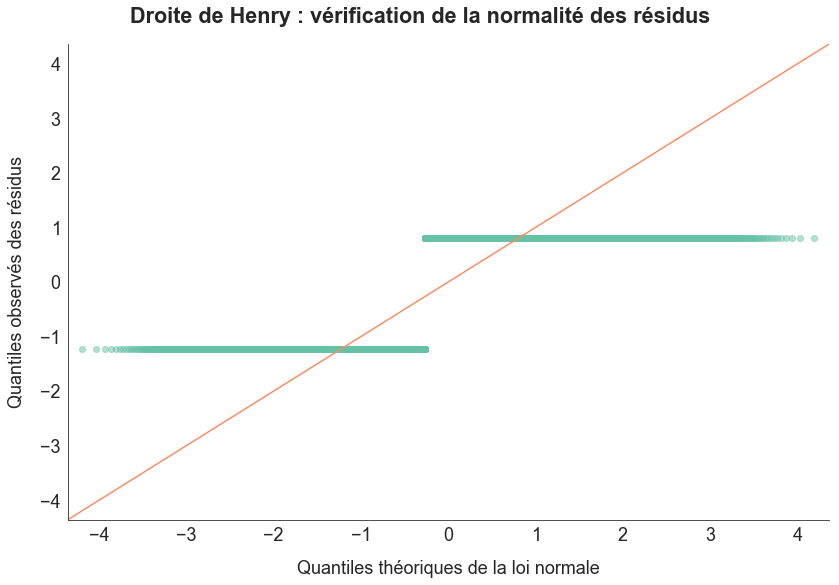

In [90]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

La somme des signaux ne permet d'anticiper l'existence future d'une tendance à 21 jours. On note que les résidus ne suivent plus du tout une loi normale.

**Variation à 2 mois**

In [91]:
data_model = logistic_alea42[["somme_signaux","tendance_cluster"]].copy()
len(data_model)

71679

In [92]:
anova = smf.ols(formula="tendance_cluster ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     3416.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:21   Log-Likelihood:                -48832.
No. Observations:               71679   AIC:                         9.767e+04
Df Residuals:                   71677   BIC:                         9.769e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5845      0.002    322.686      0.000       0.581       0.588
somme_signaux     0.0004   6.28e-06     58.450      0.000       0.000       0.000
==============================================================================
Omnibus:                   333054.576   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10051.476
Skew:                          -0.410   Prob(JB):                         0.00
Kurtosis:                       1.359   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le résultat est un peu meilleur pour détecter les tendances à 2 mois, mais encore trop imprécis pour être exploité.

**Variation à 3 mois**

In [93]:
data_model = logistic_alea64[["somme_signaux","tendance_cluster"]].copy()
len(data_model)

71455

In [94]:
anova = smf.ols(formula="tendance_cluster ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     7118.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:21   Log-Likelihood:                -36547.
No. Observations:               71455   AIC:                         7.310e+04
Df Residuals:                   71453   BIC:                         7.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7424      0.002    483.246      0.000       0.739       0.745
somme_signaux     0.0005   5.34e-06     84.370      0.000       0.000       0.000
==============================================================================
Omnibus:                     9929.064   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14217.517
Skew:                          -1.081   Prob(JB):                         0.00
Kurtosis:                       2.677   Cond. No.                         293.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C'est encore meilleur à 3 mois, mais l'alignement est toujours trop faible pour que l'estimation soit fiable.

### 3.3.2. Modélisation basée sur la somme des signaux par indicateur sans interaction

**Variation à 1 mois**

In [95]:
data_model = logistic_alea21[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71893

In [96]:
anova = smf.ols(formula="tendance_cluster ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.22
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           2.90e-09
Time:                        10:33:21   Log-Likelihood:                -50567.
No. Observations:               71893   AIC:                         1.011e+05
Df Residuals:                   71889   BIC:                         1.012e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6035      0.002    327.516      0.000       0.600       0.607
BRO           -0.0002   5.58e-05     -3.647      0.000      -0.000   -9.42e-05
FOT            0.0004   6.42e-05      6.467      0.000       0.000       0.001
MOM        -9.684e-05   5.71e-05     -1.697      0.090      -0.000     1.5e-05
==============================================================================
Omnibus:                   279011.842   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12052.882
Skew:                          -0.425   Prob(JB):                         0.00
Kurtosis:                       1.183   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
BRO,3.179746,1.0,13.301877,2.653277e-04,0.000185,0.000171
FOT,9.997514,1.0,41.822744,1.005726e-10,0.000581,0.000567
MOM,0.688425,1.0,2.879897,8.969609e-02,0.000040,0.000026
Residual,17184.699416,71889.0,NaN,NaN,NaN,NaN
total,17198.565101,71892.0,NaN,NaN,NaN,NaN


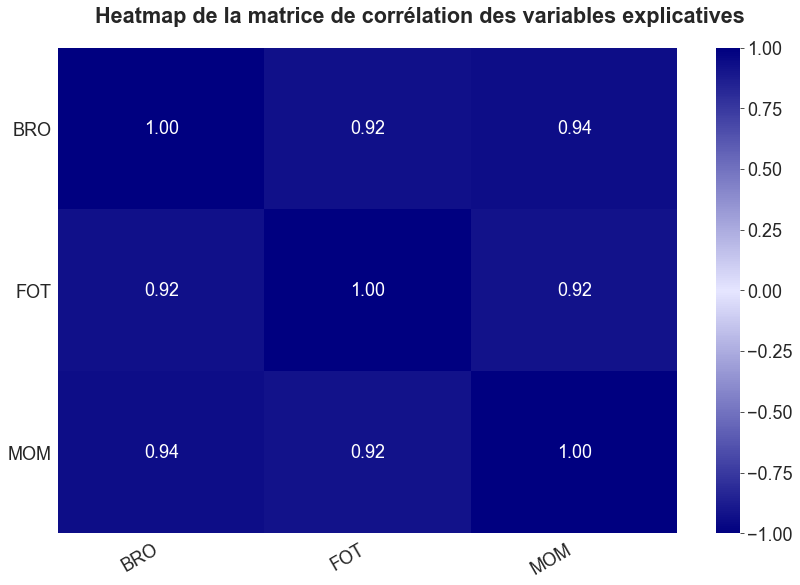

In [98]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

Nous avons bien évidemment toujours le même problème de colinéarité. Je choisis une nouvelle fois FOT comme indicateur pour mon modèle.

In [99]:
anova = smf.ols(formula="tendance_cluster ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.000
Date:                Tue, 26 Nov 2019   Prob (F-statistic):             0.0455
Time:                        10:33:21   Log-Likelihood:                -50586.
No. Observations:               71893   AIC:                         1.012e+05
Df Residuals:                   71891   BIC:                         1.012e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6035      0.002    327.457      0.000       0.600       0.607
FOT         4.546e-05   2.27e-05      2.000      0.046    9.09e-07       9e-05
==============================================================================
Omnibus:                   278622.306   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12077.883
Skew:                          -0.426   Prob(JB):                         0.00
Kurtosis:                       1.181   Cond. No.                         81.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

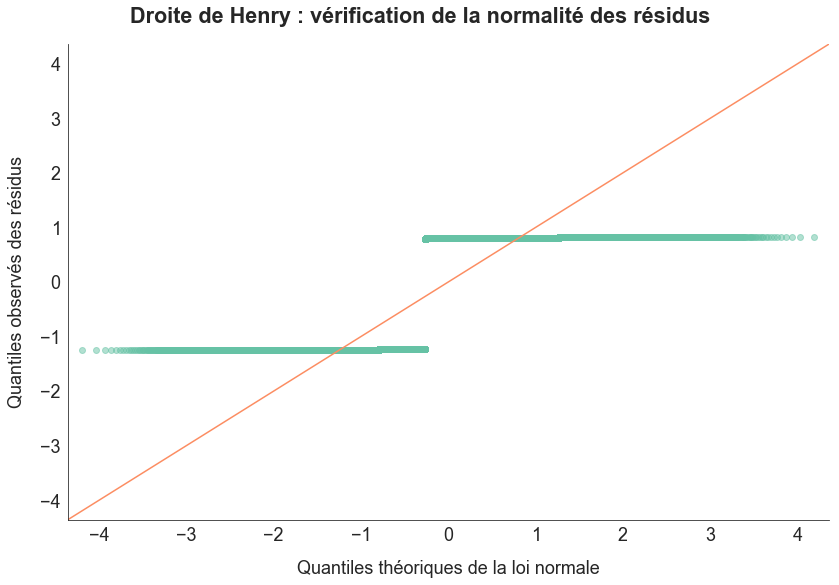

In [100]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Avec un R² nul, le modèle est totalement inexploitable.

**Variation à 2 mois**

In [101]:
data_model = logistic_alea42[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71679

In [102]:
anova = smf.ols(formula="tendance_cluster ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1154.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:22   Log-Likelihood:                -48810.
No. Observations:               71679   AIC:                         9.763e+04
Df Residuals:                   71675   BIC:                         9.766e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5847      0.002    322.673      0.000       0.581       0.588
BRO            0.0001   5.46e-05      2.713      0.007    4.11e-05       0.000
FOT            0.0002   6.27e-05      2.990      0.003    6.46e-05       0.000
MOM            0.0007   5.62e-05     13.073      0.000       0.001       0.001
==============================================================================
Omnibus:                   333902.645   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10021.790
Skew:                          -0.409   Prob(JB):                         0.00
Kurtosis:                       1.361   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
BRO,1.682254,1.0,7.359937,6.670904e-03,0.000102,0.000088
FOT,2.043732,1.0,8.941423,2.788701e-03,0.000124,0.000110
MOM,39.062221,1.0,170.899011,5.217999e-39,0.002378,0.002364
Residual,16382.684926,71675.0,NaN,NaN,NaN,NaN
total,16425.473133,71678.0,NaN,NaN,NaN,NaN


Je garde maintenant l'indicateur MOM qui a un meilleur omega² et dont le coefficient présente une une p-value plus faible.

In [104]:
anova = smf.ols(formula="tendance_cluster ~ MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3432.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:22   Log-Likelihood:                -48824.
No. Observations:               71679   AIC:                         9.765e+04
Df Residuals:                   71677   BIC:                         9.767e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5853      0.002    323.641      0.000       0.582       0.589
MOM            0.0010   1.73e-05     58.584      0.000       0.001       0.001
==============================================================================
Omnibus:                   332844.838   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10028.735
Skew:                          -0.407   Prob(JB):                         0.00
Kurtosis:                       1.359   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [105]:
data_model = logistic_alea64[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71455

In [106]:
anova = smf.ols(formula="tendance_cluster ~ BRO + FOT + MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     2386.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:22   Log-Likelihood:                -36529.
No. Observations:               71455   AIC:                         7.307e+04
Df Residuals:                   71451   BIC:                         7.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7418      0.002    482.288      0.000       0.739       0.745
BRO            0.0004   4.63e-05      8.717      0.000       0.000       0.000
FOT            0.0008   5.31e-05     14.145      0.000       0.001       0.001
MOM            0.0003   4.76e-05      5.676      0.000       0.000       0.000
==============================================================================
Omnibus:                     9930.490   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14252.433
Skew:                          -1.082   Prob(JB):                         0.00
Kurtosis:                       2.684   Cond. No.                         171.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
table_anova = sm.stats.anova_lm(anova, typ=3)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
Intercept,37861.738688,1.0,232601.809872,0.000000e+00,0.764230,0.764205
BRO,12.367952,1.0,75.981928,2.922644e-18,0.000250,0.000236
FOT,32.566484,1.0,200.070665,2.321287e-45,0.000657,0.000643
MOM,5.243996,1.0,32.216241,1.384654e-08,0.000106,0.000092
Residual,11630.430100,71451.0,NaN,NaN,NaN,NaN
total,49542.347220,71455.0,NaN,NaN,NaN,NaN


Je garde l'indicateur FOT sur la base de l'omega² plus élevé.

In [108]:
anova = smf.ols(formula="tendance_cluster ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     6852.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:22   Log-Likelihood:                -36668.
No. Observations:               71455   AIC:                         7.334e+04
Df Residuals:                   71453   BIC:                         7.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7418      0.002    481.328      0.000       0.739       0.745
FOT            0.0016    1.9e-05     82.775      0.000       0.002       0.002
==============================================================================
Omnibus:                    10087.215   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14619.017
Skew:                          -1.097   Prob(JB):                         0.00
Kurtosis:                       2.695   Cond. No.                         82.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On note des améliorations sur l'anticipation des tendances à 2 mois et à 3 mois par rapport aux anticipations à 1 mois. Mais la qualité des résultats est toujours insuffisante, notamment à cause d'un faible alignement linéaire des données.

### 3.3.3. Modélisation basée sur la somme des signaux par indicateur avec interaction

**Variation à 1 mois**

In [109]:
data_model = logistic_alea21[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71893

In [110]:
anova = smf.ols(formula="tendance_cluster ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     4474.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:33:23   Log-Likelihood:                -37588.
No. Observations:               71893   AIC:                         7.519e+04
Df Residuals:                   71885   BIC:                         7.526e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9168      0.002    384.270      0.000       0.912       0.921
BRO            -0.0001   4.71e-05     -3.157      0.002      -0.000   -5.63e-05
FOT             0.0003    6.1e-05      4.141      0.000       0.000       0.000
BRO:FOT     -2.402e-05   7.46e-07    -32.206      0.000   -2.55e-05   -2.26e-05
MOM            -0.0002   5.07e-05     -3.908      0.000      -0.000   -9.88e-05
BRO:MOM     -7.409e-06    4.2e-07    -17.659      0.000   -8.23e-06   -6.59e-06
FOT:MOM     -5.068e-06   7.83e-07     -6.472      0.000    -6.6e-06   -3.53e-06
BRO:FOT:MOM  3.313e-08   2.89e-09     11.452      0.000    2.75e-08    3.88e-08
==============================================================================
Omnibus:                     3014.854   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1278.931
Skew:                          -0.024   Prob(JB):                    1.92e-278
Kurtosis:                       2.348   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

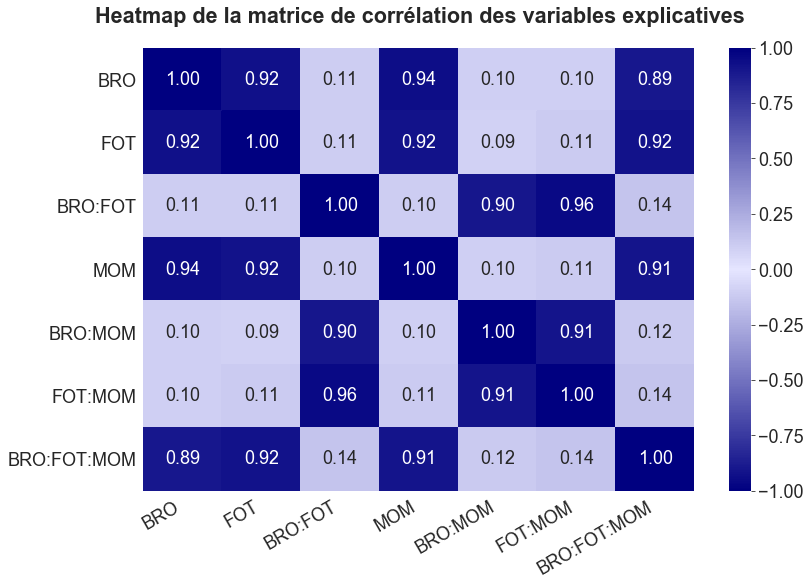

In [181]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [114]:
anova = smf.ols(formula="tendance_cluster ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                 1.344e+04
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:35:30   Log-Likelihood:                -39170.
No. Observations:               71893   AIC:                         7.835e+04
Df Residuals:                   71890   BIC:                         7.837e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8997      0.002    375.619      0.000       0.895       0.904
FOT            0.0003   1.95e-05     16.644      0.000       0.000       0.000
BRO:MOM    -2.775e-05   1.69e-07   -163.926      0.000   -2.81e-05   -2.74e-05
==============================================================================
Omnibus:                     5360.798   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1800.435
Skew:                          -0.037   Prob(JB):                         0.00
Kurtosis:                       2.228   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

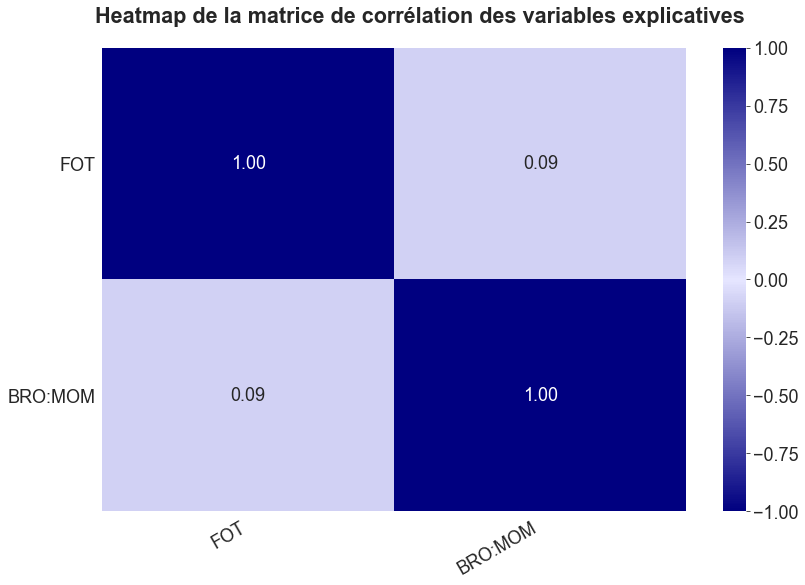

In [184]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [186]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.007678
BRO:MOM,1.007678


In [187]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
FOT,48.230938,1.0,277.038006,4.340387e-62,0.002797,0.002783
BRO:MOM,4678.252546,1.0,26871.833724,0.000000e+00,0.271326,0.271308
Residual,12515.691300,71890.0,NaN,NaN,NaN,NaN
total,17242.174784,71892.0,NaN,NaN,NaN,NaN


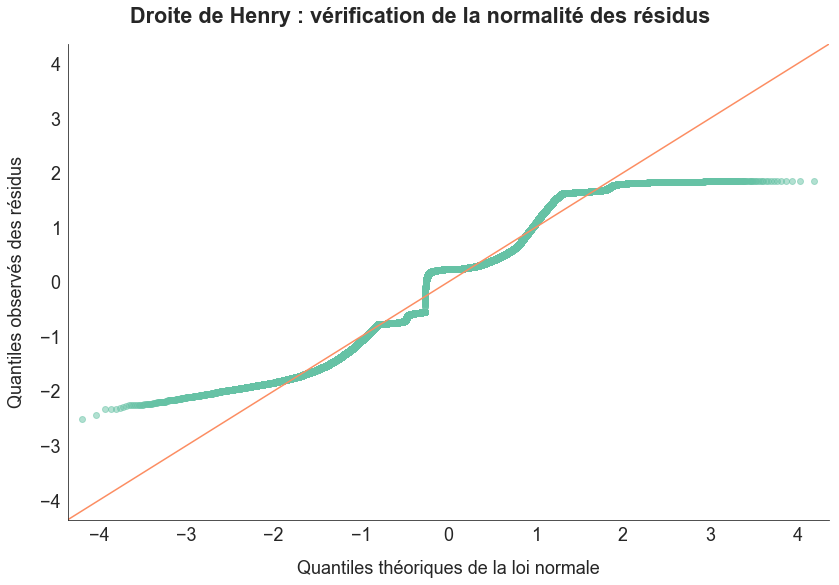

In [188]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

L'étude des interactions entre les indicateurs nous a menés à conserver la somme des signaux pour l'indicateur FOT associée à l'interaction de la somme des signaux pour les indicateurs BRO et MOM. Ce modèle permet d'améliorer la prédiction de l'existence d'une tendance à 1 mois, même si la partie de variance expliquée par le modèle reste faible (27.2%).

**Variation à 2 mois**

In [189]:
data_model = logistic_alea42[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71679

In [190]:
anova = smf.ols(formula="tendance_cluster ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     976.0
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:22:06   Log-Likelihood:                -47237.
No. Observations:               71679   AIC:                         9.449e+04
Df Residuals:                   71671   BIC:                         9.456e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6783      0.003    247.347      0.000       0.673       0.684
BRO          3.215e-05   5.41e-05      0.595      0.552   -7.38e-05       0.000
FOT            -0.0007   6.99e-05     -9.529      0.000      -0.001      -0.001
BRO:FOT     -7.551e-06   8.65e-07     -8.732      0.000   -9.25e-06   -5.86e-06
MOM             0.0002   5.88e-05      3.463      0.001    8.84e-05       0.000
BRO:MOM      4.236e-06   4.81e-07      8.806      0.000    3.29e-06    5.18e-06
FOT:MOM     -1.002e-05   9.02e-07    -11.111      0.000   -1.18e-05   -8.25e-06
BRO:FOT:MOM  1.028e-07   3.33e-09     30.843      0.000    9.63e-08    1.09e-07
==============================================================================
Omnibus:                   491384.390   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8829.283
Skew:                          -0.454   Prob(JB):                         0.00
Kurtosis:                       1.541   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

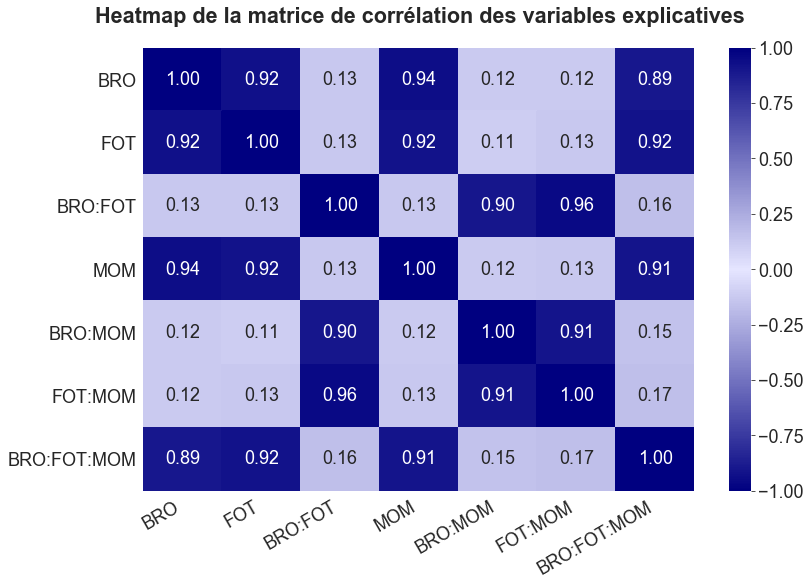

In [191]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [192]:
anova = smf.ols(formula="tendance_cluster ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     2269.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:23:13   Log-Likelihood:                -48300.
No. Observations:               71679   AIC:                         9.661e+04
Df Residuals:                   71676   BIC:                         9.663e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6616      0.003    242.275      0.000       0.656       0.667
FOT            0.0013   2.23e-05     59.738      0.000       0.001       0.001
BRO:MOM    -7.211e-06   1.93e-07    -37.361      0.000   -7.59e-06   -6.83e-06
==============================================================================
Omnibus:                   377058.108   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9600.507
Skew:                          -0.440   Prob(JB):                         0.00
Kurtosis:                       1.437   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.011618
BRO:MOM,1.011618


In [194]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova


,sum_sq,df,F,PR(>F),eta_squared,omega_squared
FOT,804.150689,1.0,3568.646628,0.000000e+00,0.046563,0.046549
BRO:MOM,314.544340,1.0,1395.879669,1.366878e-302,0.018213,0.018199
Residual,16151.306303,71676.0,NaN,NaN,NaN,NaN
total,17270.001332,71678.0,NaN,NaN,NaN,NaN


L'existence des tendances à 2 mois n'est pas bien modélisée par notre modèle.

**Variation à 3 mois**

In [195]:
data_model = logistic_alea64[["BRO","FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71455

In [197]:
anova = smf.ols(formula="tendance_cluster ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3429.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:25:21   Log-Likelihood:                -36665.
No. Observations:               71455   AIC:                         7.334e+04
Df Residuals:                   71452   BIC:                         7.336e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7463      0.002    320.889      0.000       0.742       0.751
FOT            0.0016   1.92e-05     82.463      0.000       0.002       0.002
BRO:MOM    -4.268e-07   1.65e-07     -2.584      0.010   -7.51e-07   -1.03e-07
==============================================================================
Omnibus:                    10086.709   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14663.913
Skew:                          -1.100   Prob(JB):                         0.00
Kurtosis:                       2.705   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
FOT,1.01549
BRO:MOM,1.01549


In [199]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
FOT,1111.100983,1.0,6800.208143,0.000000,0.086894,0.086879
BRO:MOM,1.090895,1.0,6.676546,0.009771,0.000085,0.000071
Residual,11674.699624,71452.0,NaN,NaN,NaN,NaN
total,12786.891502,71454.0,NaN,NaN,NaN,NaN


L'existence de tendances à 3 mois n'est pas bien modélisée.

### 3.3.4. Modélisation basée sur la somme des signaux par indicateur avec FOT comme trigger

**Variation à 1 mois**

In [201]:
data_model = logistic_alea21[["BRO","trigger_FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71893

In [202]:
anova = smf.ols(formula="tendance_cluster ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     4336.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:30:20   Log-Likelihood:                -37928.
No. Observations:               71893   AIC:                         7.587e+04
Df Residuals:                   71885   BIC:                         7.594e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9200      0.002    378.146      0.000       0.915       0.925
BRO                  1.042e-05   4.39e-05      0.237      0.812   -7.57e-05    9.65e-05
trigger_FOT            -0.5747      0.012    -47.650      0.000      -0.598      -0.551
BRO:trigger_FOT        -0.0002      0.000     -1.302      0.193      -0.001       0.000
MOM                  4.065e-05   4.76e-05      0.855      0.393   -5.26e-05       0.000
BRO:MOM             -2.742e-05   2.26e-07   -121.350      0.000   -2.79e-05    -2.7e-05
trigger_FOT:MOM         0.0006      0.000      3.745      0.000       0.000       0.001
BRO:trigger_FOT:MOM  2.477e-05   6.21e-07     39.857      0.000    2.35e-05     2.6e-05
==============================================================================
Omnibus:                     3530.434   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1406.157
Skew:                           0.014   Prob(JB):                    4.54e-306
Kurtosis:                       2.315   Cond. No.                     1.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

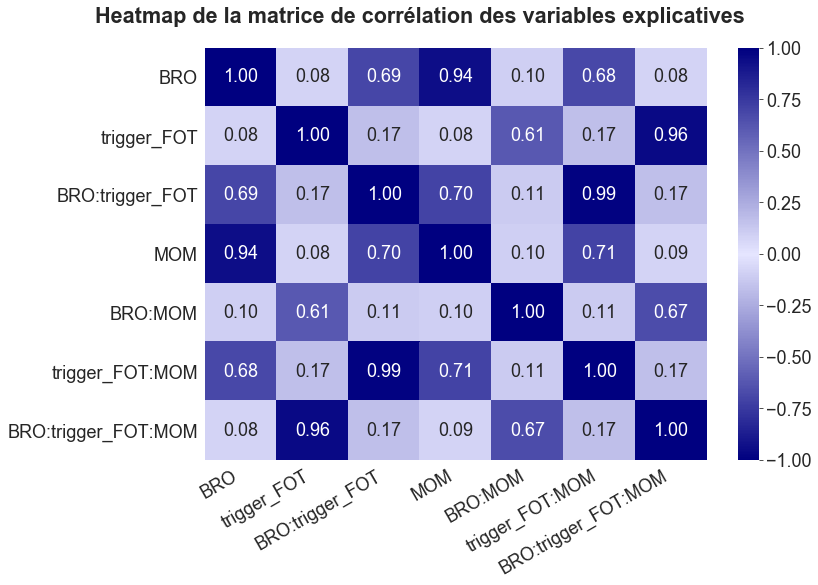

In [203]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

L'analyse de la multicolinéarité simple montre qu'il faut :
- choisir entre BRO et MOM ;
- choisir entre l'interaction entre BRO et trigger_FOT et l'interaction entre trigger_FOT et MOM ;
- choisir entre trigger_FOT et la triple interaction.  
  
Je conserve MOM, trigger_FOT, MOM:trigger_FOT et BRO:MOM (basé sur les p-values inférieures des coefficients liés à MOM par rapport à ceux liés à BRO). Ainsi je conserve les 2 variables MOM et trigger_FOT avec leur interaction, plus l'interaction BRO:MOM qui permet d'introduire l'indicateur BRO.

In [206]:
anova = smf.ols(formula="tendance_cluster ~ MOM * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     7034.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:39:38   Log-Likelihood:                -38714.
No. Observations:               71893   AIC:                         7.744e+04
Df Residuals:                   71888   BIC:                         7.748e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8966      0.002    375.676      0.000       0.892       0.901
MOM               2.65e-05   2.13e-05      1.243      0.214   -1.53e-05    6.83e-05
trigger_FOT        -0.1264      0.004    -28.746      0.000      -0.135      -0.118
MOM:trigger_FOT     0.0004   3.01e-05     14.923      0.000       0.000       0.001
BRO:MOM         -2.414e-05   2.13e-07   -113.479      0.000   -2.46e-05   -2.37e-05
==============================================================================
Omnibus:                     3956.812   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1554.253
Skew:                          -0.074   Prob(JB):                         0.00
Kurtosis:                       2.295   Cond. No.                     4.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [217]:
anova = smf.ols(formula="tendance_cluster ~ trigger_FOT + trigger_FOT:MOM + MOM:BRO", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     9379.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:46:04   Log-Likelihood:                -38715.
No. Observations:               71893   AIC:                         7.744e+04
Df Residuals:                   71889   BIC:                         7.747e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8966      0.002    375.853      0.000       0.892       0.901
trigger_FOT        -0.1269      0.004    -28.959      0.000      -0.135      -0.118
trigger_FOT:MOM     0.0005   2.12e-05     22.414      0.000       0.000       0.001
MOM:BRO         -2.412e-05   2.12e-07   -113.698      0.000   -2.45e-05   -2.37e-05
==============================================================================
Omnibus:                     3961.165   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1555.210
Skew:                          -0.074   Prob(JB):                         0.00
Kurtosis:                       2.295   Cond. No.                     4.03e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [218]:
table_anova = sm.stats.anova_lm(anova, typ=1)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,df,sum_sq,mean_sq,F,PR(>F),eta_squared,omega_squared
trigger_FOT,1.0,2537.959013,2537.959013,14763.665605,0.000000e+00,0.147600,0.147584
trigger_FOT:MOM,1.0,76.560536,76.560536,445.363439,1.468399e-98,0.004453,0.004439
MOM:BRO,1.0,2222.248470,2222.248470,12927.132838,0.000000e+00,0.129239,0.129223
Residual,71889.0,12358.132485,0.171906,NaN,NaN,NaN,NaN
total,71892.0,17194.900505,NaN,NaN,NaN,NaN,NaN


In [219]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
trigger_FOT,119.428363,1.0,694.731637,2.227009e-152,0.008077,0.008063
trigger_FOT:MOM,86.361390,1.0,502.376386,6.947597e-111,0.005841,0.005827
MOM:BRO,2222.248470,1.0,12927.132838,0.000000e+00,0.150292,0.150276
Residual,12358.132485,71889.0,NaN,NaN,NaN,NaN
total,14786.170708,71892.0,NaN,NaN,NaN,NaN


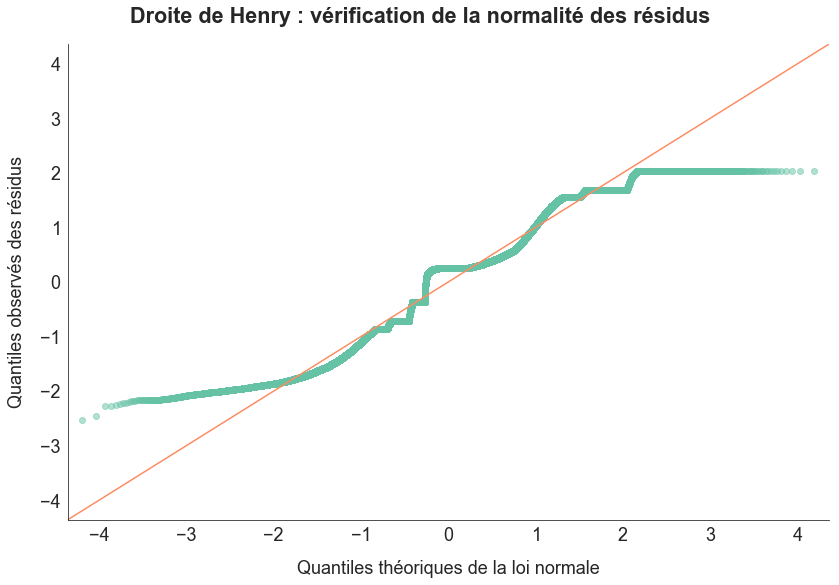

In [214]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Selon que l'on analyse le modèle selon l'ANOVA de type 1 ou de type 2, la proportion de la variance expliquée par le modèle varie de 28,1% à 16.4%. Dans les 2 cas, cela reste faible pour avoir un modèle performant.

**Variation à 2 mois**

In [220]:
data_model = logistic_alea42[["BRO","trigger_FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71679

In [221]:
anova = smf.ols(formula="tendance_cluster ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     875.2
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:48:53   Log-Likelihood:                -47561.
No. Observations:               71679   AIC:                         9.514e+04
Df Residuals:                   71671   BIC:                         9.521e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6638      0.003    237.723      0.000       0.658       0.669
BRO                     0.0002   5.06e-05      3.475      0.001    7.66e-05       0.000
trigger_FOT            -0.1546      0.014    -11.136      0.000      -0.182      -0.127
BRO:trigger_FOT        -0.0003      0.000     -1.433      0.152      -0.001     9.6e-05
MOM                     0.0005   5.49e-05      9.715      0.000       0.000       0.001
BRO:MOM             -4.226e-06   2.59e-07    -16.329      0.000   -4.73e-06   -3.72e-06
trigger_FOT:MOM         0.0011      0.000      5.678      0.000       0.001       0.001
BRO:trigger_FOT:MOM  1.533e-06   7.15e-07      2.144      0.032    1.32e-07    2.93e-06
==============================================================================
Omnibus:                   449097.483   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9105.525
Skew:                          -0.457   Prob(JB):                         0.00
Kurtosis:                       1.513   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

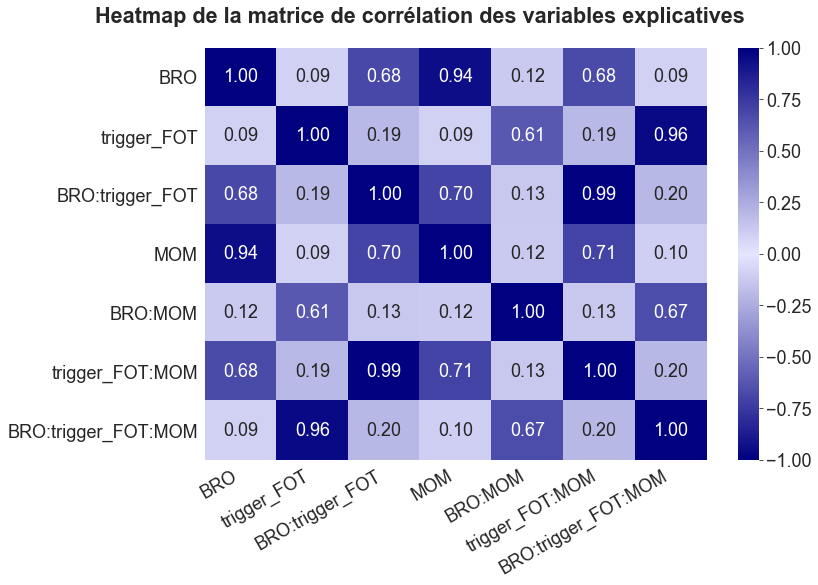

In [222]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [223]:
anova = smf.ols(formula="tendance_cluster ~ MOM * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1527.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:58:17   Log-Likelihood:                -47569.
No. Observations:               71679   AIC:                         9.515e+04
Df Residuals:                   71674   BIC:                         9.519e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6625      0.003    244.492      0.000       0.657       0.668
MOM                 0.0007   2.43e-05     28.906      0.000       0.001       0.001
trigger_FOT        -0.1273      0.005    -25.412      0.000      -0.137      -0.117
MOM:trigger_FOT     0.0008   3.43e-05     23.578      0.000       0.001       0.001
BRO:MOM         -4.014e-06   2.41e-07    -16.638      0.000   -4.49e-06   -3.54e-06
==============================================================================
Omnibus:                   446610.836   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9124.559
Skew:                          -0.458   Prob(JB):                         0.00
Kurtosis:                       1.511   Cond. No.                     4.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [224]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
MOM,2.033486
trigger_FOT,1.649501
MOM:trigger_FOT,2.079099
BRO:MOM,1.612727


Encore une fois, la modélisation de l'existence d'une tendance à 2 mois est moins performante que pour la tendance à 1 mois.

**Variation à 3 mois**

In [225]:
data_model = logistic_alea64[["BRO","trigger_FOT","MOM","tendance_cluster"]].copy()
len(data_model)

71455

In [226]:
anova = smf.ols(formula="tendance_cluster ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1064.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:00:00   Log-Likelihood:                -36398.
No. Observations:               71455   AIC:                         7.281e+04
Df Residuals:                   71447   BIC:                         7.289e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7477      0.002    312.334      0.000       0.743       0.752
BRO                     0.0006   4.36e-05     14.456      0.000       0.001       0.001
trigger_FOT            -0.0633      0.012     -5.293      0.000      -0.087      -0.040
BRO:trigger_FOT         0.0002      0.000      1.503      0.133   -7.06e-05       0.001
MOM                     0.0004   4.73e-05      8.465      0.000       0.000       0.000
BRO:MOM              1.677e-06   2.22e-07      7.535      0.000    1.24e-06    2.11e-06
trigger_FOT:MOM         0.0002      0.000      1.024      0.306      -0.000       0.000
BRO:trigger_FOT:MOM -9.837e-07   6.16e-07     -1.597      0.110   -2.19e-06    2.23e-07
==============================================================================
Omnibus:                     9857.087   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14268.207
Skew:                          -1.086   Prob(JB):                         0.00
Kurtosis:                       2.724   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

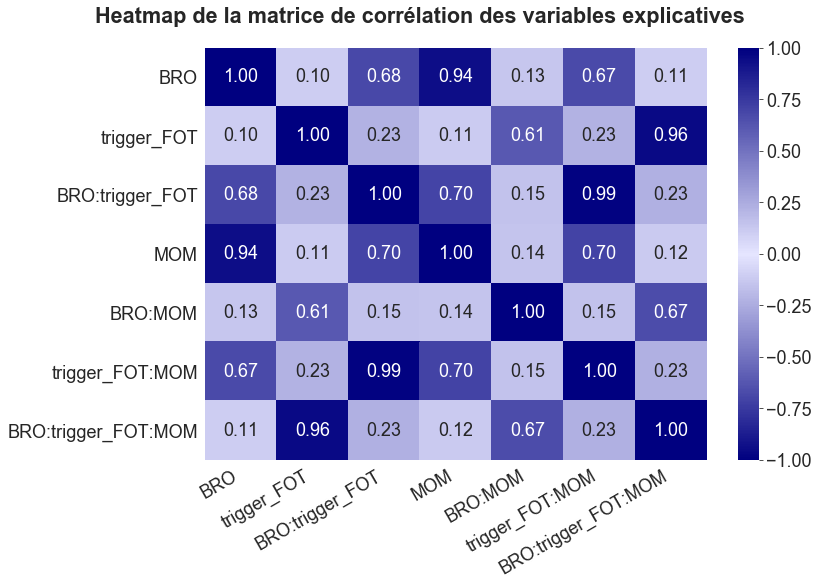

In [227]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [228]:
anova = smf.ols(formula="tendance_cluster ~ BRO * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       tendance_cluster   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     1837.
Date:                Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:01:40   Log-Likelihood:                -36442.
No. Observations:               71455   AIC:                         7.289e+04
Df Residuals:                   71450   BIC:                         7.294e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7482      0.002    321.805      0.000       0.744       0.753
BRO                 0.0010   1.92e-05     49.997      0.000       0.001       0.001
trigger_FOT        -0.0821      0.004    -18.947      0.000      -0.091      -0.074
BRO:trigger_FOT     0.0004   2.82e-05     15.742      0.000       0.000       0.000
BRO:MOM          1.637e-06   2.07e-07      7.897      0.000    1.23e-06    2.04e-06
==============================================================================
Omnibus:                     9888.039   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14333.866
Skew:                          -1.088   Prob(JB):                         0.00
Kurtosis:                       2.725   Cond. No.                     4.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [229]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
BRO,1.895446
trigger_FOT,1.662439
BRO:trigger_FOT,1.959993
BRO:MOM,1.609931


La modélisation de l'existence d'une tendance à 3 mois n'est toujours pas convaincante.

<a id='3_4'></a>

### 3.4. Régression logistique pour modéliser la présence d'une tendance (tendance basée sur les seuils)

Tous les calculs de multicolinéarité ne sont plus nécessaires car seule la variable endogène change (tendance_cluster remplacé par tendance_seuil). Je peux donc passer directement au modèle final choisi précédemment dans chaque cas.

### 3.4.1. Modélisation basée sur la somme globale des signaux

**Variation à 1 mois**

In [232]:
data_model = logistic_alea21[["somme_signaux","tendance_seuil"]].copy()
len(data_model)

71893

In [233]:
anova = smf.ols(formula="tendance_seuil ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     324.6
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           2.11e-72
Time:                        23:12:13   Log-Likelihood:                -51567.
No. Observations:               71893   AIC:                         1.031e+05
Df Residuals:                   71891   BIC:                         1.032e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5511      0.002    295.211      0.000       0.547       0.555
somme_signaux     0.0001   6.48e-06     18.016      0.000       0.000       0.000
==============================================================================
Omnibus:                   255833.524   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11777.278
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                       1.068   Cond. No.                         291.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 2 mois**

In [234]:
data_model = logistic_alea42[["somme_signaux","tendance_seuil"]].copy()
len(data_model)

71679

In [235]:
anova = smf.ols(formula="tendance_seuil ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     602.6
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.61e-132
Time:                        23:12:53   Log-Likelihood:                -51605.
No. Observations:               71679   AIC:                         1.032e+05
Df Residuals:                   71677   BIC:                         1.032e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5211      0.002    276.768      0.000       0.517       0.525
somme_signaux     0.0002   6.53e-06     24.548      0.000       0.000       0.000
==============================================================================
Omnibus:                   251298.417   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11551.862
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.047   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [236]:
data_model = logistic_alea64[["somme_signaux","tendance_seuil"]].copy()
len(data_model)

71455

In [237]:
anova = smf.ols(formula="tendance_seuil ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     631.7
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          8.62e-139
Time:                        23:13:14   Log-Likelihood:                -51529.
No. Observations:               71455   AIC:                         1.031e+05
Df Residuals:                   71453   BIC:                         1.031e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5025      0.002    265.219      0.000       0.499       0.506
somme_signaux     0.0002   6.58e-06     25.133      0.000       0.000       0.000
==============================================================================
Omnibus:                   248958.891   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11494.930
Skew:                          -0.046   Prob(JB):                         0.00
Kurtosis:                       1.037   Cond. No.                         293.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Comme je m'en doutais, la somme des signaux ne permet pas de modéliser l'existence d'une tendance.

### 3.4.2. Modélisation basée sur la somme des signaux par indicateur sans interaction

**Variation à 1 mois**

In [267]:
data_model = logistic_alea21[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71893

In [268]:
anova = smf.ols(formula="tendance_seuil ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     373.5
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           5.26e-83
Time:                        23:26:12   Log-Likelihood:                -51543.
No. Observations:               71893   AIC:                         1.031e+05
Df Residuals:                   71891   BIC:                         1.031e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5506      0.002    294.792      0.000       0.547       0.554
FOT            0.0004    2.3e-05     19.326      0.000       0.000       0.000
==============================================================================
Omnibus:                   256255.336   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11745.493
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                       1.071   Cond. No.                         81.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

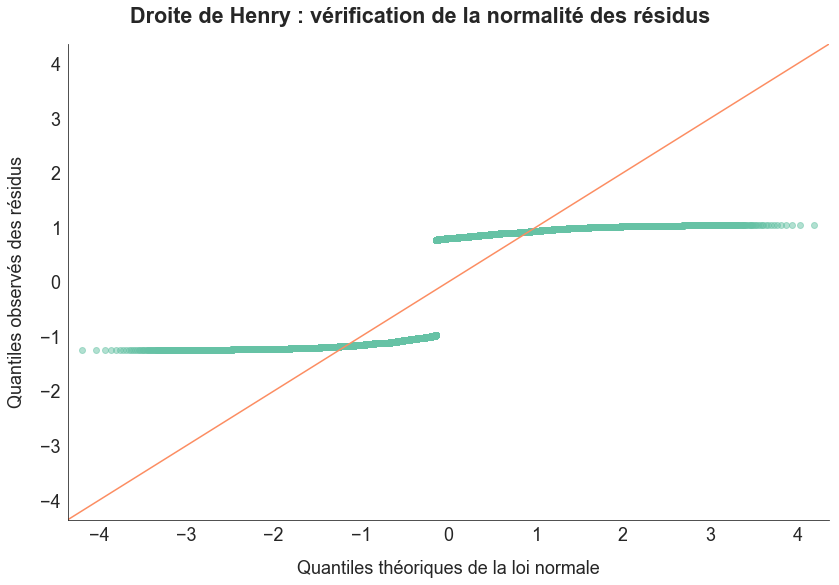

In [269]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova01_02_droite_henry.png")
plt.show()

Nous ne pouvons toujours pas estimer de façon fiable l'existence d'une tendance à 1 mois.

**Variation à 2 mois**

In [270]:
data_model = logistic_alea42[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71679

In [271]:
anova = smf.ols(formula="tendance_seuil ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     698.2
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          3.94e-153
Time:                        23:26:42   Log-Likelihood:                -51558.
No. Observations:               71679   AIC:                         1.031e+05
Df Residuals:                   71677   BIC:                         1.031e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5203      0.002    276.306      0.000       0.517       0.524
FOT            0.0006   2.32e-05     26.424      0.000       0.001       0.001
==============================================================================
Omnibus:                   252101.644   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11490.477
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.052   Cond. No.                         82.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [272]:
data_model = logistic_alea64[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71455

In [273]:
anova = smf.ols(formula="tendance_seuil ~ FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     735.1
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          4.57e-161
Time:                        23:27:01   Log-Likelihood:                -51478.
No. Observations:               71455   AIC:                         1.030e+05
Df Residuals:                   71453   BIC:                         1.030e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5014      0.002    264.440      0.000       0.498       0.505
FOT            0.0006   2.34e-05     27.113      0.000       0.001       0.001
==============================================================================
Omnibus:                   249807.387   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11428.869
Skew:                          -0.046   Prob(JB):                         0.00
Kurtosis:                       1.043   Cond. No.                         82.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Toujours aucun modèle satisfaisant pour anticiper les tendances à 1 mois, à 2 mois ou à 3 mois.

### 3.4.3. Modélisation basée sur la somme des signaux par indicateur avec interaction

**Variation à 1 mois**

In [274]:
data_model = logistic_alea21[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71893

In [275]:
anova = smf.ols(formula="tendance_seuil ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     208.5
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           5.23e-91
Time:                        23:27:15   Log-Likelihood:                -51521.
No. Observations:               71893   AIC:                         1.030e+05
Df Residuals:                   71890   BIC:                         1.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5647      0.003    198.544      0.000       0.559       0.570
FOT            0.0005   2.31e-05     19.832      0.000       0.000       0.001
BRO:MOM    -1.322e-06   2.01e-07     -6.576      0.000   -1.72e-06   -9.28e-07
==============================================================================
Omnibus:                   256665.986   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11716.198
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                       1.073   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Variation à 2 mois**

In [276]:
data_model = logistic_alea42[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71679

In [277]:
anova = smf.ols(formula="tendance_seuil ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     396.1
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          8.69e-172
Time:                        23:27:37   Log-Likelihood:                -51512.
No. Observations:               71679   AIC:                         1.030e+05
Df Residuals:                   71676   BIC:                         1.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5410      0.003    189.429      0.000       0.535       0.547
FOT            0.0006   2.33e-05     27.322      0.000       0.001       0.001
BRO:MOM    -1.946e-06   2.02e-07     -9.643      0.000   -2.34e-06   -1.55e-06
==============================================================================
Omnibus:                   252931.644   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11429.714
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.057   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Variation à 3 mois**

In [280]:
data_model = logistic_alea64[["BRO","FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71455

In [281]:
anova = smf.ols(formula="tendance_seuil ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     472.0
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          2.38e-204
Time:                        23:29:23   Log-Likelihood:                -51374.
No. Observations:               71455   AIC:                         1.028e+05
Df Residuals:                   71452   BIC:                         1.028e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5321      0.003    186.245      0.000       0.527       0.538
FOT            0.0007   2.36e-05     28.720      0.000       0.001       0.001
BRO:MOM    -2.918e-06   2.03e-07    -14.376      0.000   -3.32e-06   -2.52e-06
==============================================================================
Omnibus:                   251530.701   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11299.067
Skew:                          -0.048   Prob(JB):                         0.00
Kurtosis:                       1.054   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

L'existence de tendances à 1 mois, 2 mois ou 3 mois n'est toujours pas bien modélisée.

### 3.4.4. Modélisation basée sur la somme des signaux par indicateur avec FOT comme trigger

**Variation à 1 mois**

In [282]:
data_model = logistic_alea21[["BRO","trigger_FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71893

In [283]:
anova = smf.ols(formula="tendance_seuil ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     50.62
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           2.18e-72
Time:                        23:30:02   Log-Likelihood:                -51552.
No. Observations:               71893   AIC:                         1.031e+05
Df Residuals:                   71885   BIC:                         1.032e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5667      0.003    192.706      0.000       0.561       0.572
BRO                     0.0001   5.31e-05      2.621      0.009    3.51e-05       0.000
trigger_FOT             0.0112      0.015      0.767      0.443      -0.017       0.040
BRO:trigger_FOT        -0.0002      0.000     -0.944      0.345      -0.001       0.000
MOM                     0.0001   5.75e-05      2.494      0.013    3.07e-05       0.000
BRO:MOM             -1.845e-06   2.73e-07     -6.755      0.000   -2.38e-06   -1.31e-06
trigger_FOT:MOM         0.0002      0.000      1.267      0.205      -0.000       0.001
BRO:trigger_FOT:MOM  2.432e-07   7.51e-07      0.324      0.746   -1.23e-06    1.72e-06
==============================================================================
Omnibus:                   256117.911   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11757.005
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                       1.070   Cond. No.                     1.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [285]:
anova = smf.ols(formula="tendance_seuil ~ MOM * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     86.84
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           9.94e-74
Time:                        23:31:29   Log-Likelihood:                -51556.
No. Observations:               71893   AIC:                         1.031e+05
Df Residuals:                   71888   BIC:                         1.032e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5665      0.003    198.546      0.000       0.561       0.572
MOM                 0.0003   2.55e-05     10.904      0.000       0.000       0.000
trigger_FOT         0.0153      0.005      2.914      0.004       0.005       0.026
MOM:trigger_FOT  7.212e-05   3.59e-05      2.007      0.045    1.69e-06       0.000
BRO:MOM         -1.802e-06   2.54e-07     -7.086      0.000    -2.3e-06    -1.3e-06
==============================================================================
Omnibus:                   256054.615   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11761.663
Skew:                          -0.223   Prob(JB):                         0.00
Kurtosis:                       1.070   Cond. No.                     4.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Variation à 2 mois**

In [286]:
data_model = logistic_alea42[["BRO","trigger_FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71679

In [288]:
anova = smf.ols(formula="tendance_seuil ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     96.53
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          5.58e-141
Time:                        23:32:37   Log-Likelihood:                -51569.
No. Observations:               71679   AIC:                         1.032e+05
Df Residuals:                   71671   BIC:                         1.032e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5448      0.003    184.505      0.000       0.539       0.551
BRO                  9.158e-05   5.35e-05      1.713      0.087   -1.32e-05       0.000
trigger_FOT            -0.0266      0.015     -1.814      0.070      -0.055       0.002
BRO:trigger_FOT      3.375e-05      0.000      0.175      0.861      -0.000       0.000
MOM                     0.0003   5.81e-05      4.611      0.000       0.000       0.000
BRO:MOM             -2.325e-06   2.74e-07     -8.496      0.000   -2.86e-06   -1.79e-06
trigger_FOT:MOM         0.0001      0.000      0.678      0.498      -0.000       0.001
BRO:trigger_FOT:MOM   1.62e-06   7.56e-07      2.143      0.032    1.39e-07     3.1e-06
==============================================================================
Omnibus:                   251937.967   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11504.832
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.051   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [290]:
anova = smf.ols(formula="tendance_seuil ~ MOM * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     167.0
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.50e-142
Time:                        23:33:25   Log-Likelihood:                -51573.
No. Observations:               71679   AIC:                         1.032e+05
Df Residuals:                   71674   BIC:                         1.032e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5434      0.003    189.639      0.000       0.538       0.549
MOM                 0.0004   2.57e-05     13.806      0.000       0.000       0.000
trigger_FOT         0.0026      0.005      0.488      0.626      -0.008       0.013
MOM:trigger_FOT     0.0002   3.63e-05      4.862      0.000       0.000       0.000
BRO:MOM          -2.11e-06   2.55e-07     -8.271      0.000   -2.61e-06   -1.61e-06
==============================================================================
Omnibus:                   251866.386   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11510.104
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.050   Cond. No.                     4.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [291]:
anova = smf.ols(formula="tendance_seuil ~ MOM + MOM:trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     222.5
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          1.04e-143
Time:                        23:34:34   Log-Likelihood:                -51573.
No. Observations:               71679   AIC:                         1.032e+05
Df Residuals:                   71675   BIC:                         1.032e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5433      0.003    190.026      0.000       0.538       0.549
MOM                 0.0004   2.55e-05     13.840      0.000       0.000       0.000
MOM:trigger_FOT     0.0002   3.57e-05      5.033      0.000       0.000       0.000
BRO:MOM         -2.034e-06   2.03e-07    -10.030      0.000   -2.43e-06   -1.64e-06
==============================================================================
Omnibus:                   251864.833   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11510.306
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                       1.050   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Variation à 3 mois**

In [292]:
data_model = logistic_alea64[["BRO","trigger_FOT","MOM","tendance_seuil"]].copy()
len(data_model)

71455

In [293]:
anova = smf.ols(formula="tendance_seuil ~ BRO * trigger_FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     119.2
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          7.82e-175
Time:                        23:35:13   Log-Likelihood:                -51428.
No. Observations:               71455   AIC:                         1.029e+05
Df Residuals:                   71447   BIC:                         1.029e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5355      0.003    181.254      0.000       0.530       0.541
BRO                     0.0002   5.38e-05      3.229      0.001    6.82e-05       0.000
trigger_FOT            -0.0154      0.015     -1.040      0.298      -0.044       0.014
BRO:trigger_FOT     -5.626e-05      0.000     -0.295      0.768      -0.000       0.000
MOM                     0.0002   5.84e-05      2.878      0.004    5.36e-05       0.000
BRO:MOM             -3.025e-06   2.75e-07    -11.016      0.000   -3.56e-06   -2.49e-06
trigger_FOT:MOM         0.0003      0.000      1.603      0.109      -7e-05       0.001
BRO:trigger_FOT:MOM  6.439e-07    7.6e-07      0.847      0.397   -8.46e-07    2.13e-06
==============================================================================
Omnibus:                   250586.776   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11370.627
Skew:                          -0.048   Prob(JB):                         0.00
Kurtosis:                       1.048   Cond. No.                     1.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [295]:
anova = smf.ols(formula="tendance_seuil ~ MOM * trigger_FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         tendance_seuil   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     205.7
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          9.63e-176
Time:                        23:36:00   Log-Likelihood:                -51434.
No. Observations:               71455   AIC:                         1.029e+05
Df Residuals:                   71450   BIC:                         1.029e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5352      0.003    186.710      0.000       0.530       0.541
MOM                 0.0003   2.58e-05     13.047      0.000       0.000       0.000
trigger_FOT        -0.0040      0.005     -0.757      0.449      -0.015       0.006
MOM:trigger_FOT     0.0003   3.66e-05      7.255      0.000       0.000       0.000
BRO:MOM         -2.939e-06   2.56e-07    -11.476      0.000   -3.44e-06   -2.44e-06
==============================================================================
Omnibus:                   250481.399   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11378.674
Skew:                          -0.048   Prob(JB):                         0.00
Kurtosis:                       1.047   Cond. No.                     4.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La modélisation de l'existence d'une tendance à 1 mois, 2 mois ou 3 mois n'est toujours pas convaincante.

Je passe désormais à la modélisation qui me paraît avoir le plus de chances d'aboutir : l'appartenance ou non au top_cluster, qui est celui le plus intéressant d'un point de vue profit.